In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tqdm

import os

import pickle

# From Tile to Time Series

Importo il dataframe che al suo interno contiene il trajectory dataframe originario, che riporta le traiettorie delle auto private a Milano, a cui sono state eseguite le operazioni di:
- **filtering** dei punti della traiettoria raggiungibili ad una distanza virtualmente troppo elevata
- **compression** dei punti della traiettoria entro un certo raggio ragionevole
- **mappatura delle stops** nelle varie tile_ID della tessellation

Adesso mi occupo di ottenere per ognuna delle `tile_ID` una serie temporale, che campiona ad intervalli di tempo regolari quanto è stato il numero di stops in quella stessa `tile_ID`, ottenendo così la **time series delle stops by `tile_ID`**.

In [2]:
tdf_fcs_mapped = pd.read_csv('tdf_fcs_mapped.csv', index_col = 0,
                              parse_dates = ['datetime'],
                              dtype = {'tile_ID': str})
tdf_fcs_mapped.head()

uid            datetime        lat       lng     leaving_datetime tile_ID
0  193 2007-04-03 08:05:52  45.415662  9.265230  2007-04-03 10:10:51     664
1  193 2007-04-03 10:17:23  45.437518  9.231097  2007-04-03 11:59:30     624
2  193 2007-04-03 12:01:53  45.431064  9.266437  2007-04-03 14:18:19     665
3  193 2007-04-03 14:18:19  45.416912  9.260658  2007-04-03 15:45:41     644
4  193 2007-04-03 15:45:41  45.417499  9.266004  2007-04-04 11:18:24     664

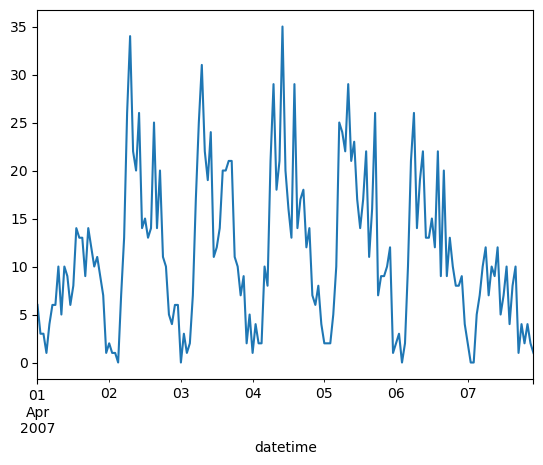

In [3]:
ts = tdf_fcs_mapped[tdf_fcs_mapped['tile_ID'] == '584']
ts.set_index('datetime', inplace = True)
ts = ts['uid']
ts = ts.resample('1h').agg("count")
ts.plot();

Scrivo una funzione che mi permette di ricavare la **time series delle stops by `tile_ID`**. In particolare:

- Se passo come argomento una **singola `tile_ID`** ottengo come risultato la **time series delle stops** attribuibili a quella **sola `tile_ID`**
- Se passo come argomento una **lista di `tile_ID`** ottengo come risultato la  **time series delle stops** attribuibili a quella **lista di `tile_ID`**

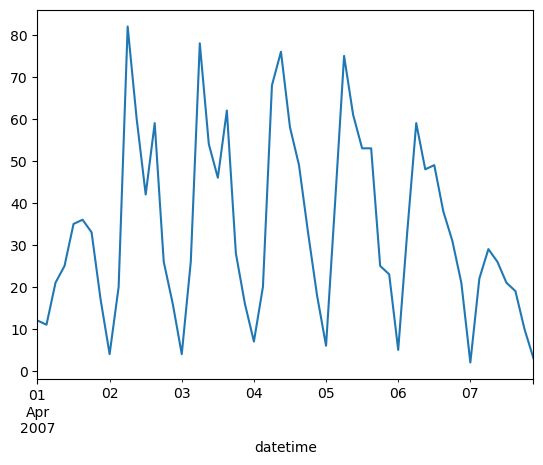

In [4]:
def get_time_series(tdf, tile_ID = None, time_unit = 'D'):
  
  if tile_ID is None:
    tdf_target = tdf
  
  else: 
    if isinstance(tile_ID, str):
      tdf_target = tdf[tdf['tile_ID'] == tile_ID]
    if isinstance(tile_ID, list):
      tdf_target = tdf[tdf['tile_ID'].isin(tile_ID)]
  
  ts = tdf_target.set_index('datetime')['uid'].resample(time_unit).agg('count')
  
  return ts

ts = get_time_series(tdf_fcs_mapped, tile_ID = '584', time_unit = '3h')
ts.plot();

# Costruzione di `df_ts`

Questo dataframe contiene tutte le time series delle stops per ogni `tile_ID` che è possibile ottenere dalle traiettorie per come sono state processate in precedenza:

In [5]:
list_ts = []

for tile in tqdm.tqdm( tdf_fcs_mapped['tile_ID'].unique() ):
  
  ts = get_time_series(tdf_fcs_mapped, tile_ID = tile, time_unit = '1h')
  if len(ts) > 0:
    ts.name = 'tile_' + tile
    list_ts.append(pd.DataFrame(ts))

df_ts = pd.concat(list_ts, axis = 1).fillna(0)
df_ts.head()

100%|██████████| 206/206 [00:02<00:00, 83.57it/s]


tile_664  tile_624  tile_665  tile_644  tile_387  \
datetime                                                                
2007-04-01 00:00:00       3.0       3.0       0.0       0.0       3.0   
2007-04-01 01:00:00       3.0       0.0       1.0       0.0       6.0   
2007-04-01 02:00:00       1.0       1.0       1.0       1.0       4.0   
2007-04-01 03:00:00       1.0       0.0       1.0       0.0       6.0   
2007-04-01 04:00:00       1.0       0.0       0.0       0.0       4.0   

                     tile_411  tile_673  tile_661  tile_642  tile_670  ...  \
datetime                                                               ...   
2007-04-01 00:00:00       0.0       9.0       2.0       0.0       5.0  ...   
2007-04-01 01:00:00       0.0       4.0       5.0       1.0       1.0  ...   
2007-04-01 02:00:00       0.0       5.0       2.0       1.0       1.0  ...   
2007-04-01 03:00:00       0.0       4.0       2.0       0.0       2.0  ...   
2007-04-01 04:00:00       0.0       3.0       5.0       1.0       0.0  ...   

                     tile_601  tile_451  tile_425  tile_505  tile_622  \
datetime                                                                
2007-04-01 00:00:00       0.0       0.0       0.0       0.0       0.0   
2007-04-01 01:00:00       0.0       0.0       0.0       0.0       0.0   
2007-04-01 02:00:00       0.0       0.0       0.0       0.0       0.0   
2007-04-01 03:00:00       0.0       0.0       0.0       0.0       0.0   
2007-04-01 04:00:00       0.0       0.0       0.0       0.0       0.0   

                     tile_400  tile_373  tile_427  tile_401  tile_375  
datetime                                                               
2007-04-01 00:00:00       0.0       0.0       0.0       0.0       0.0  
2007-04-01 01:00:00       0.0       0.0       0.0       0.0       0.0  
2007-04-01 02:00:00       0.0       0.0       0.0       0.0       0.0  
2007-04-01 03:00:00       0.0       0.0       0.0       0.0       0.0  
2007-04-01 04:00:00       0.0       0.0       0.0       0.0       0.0  

[5 rows x 206 columns]

Grafico tutte le time series:

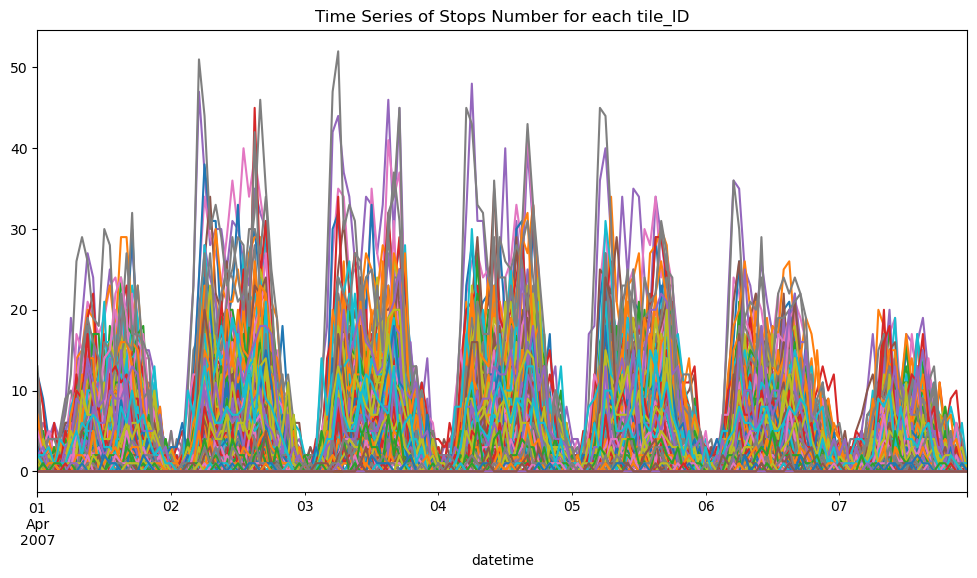

In [6]:
fig, ax = plt.subplots(figsize = [12, 6])
df_ts.plot(ax = ax, legend = False, title = 'Time Series of Stops Number for each tile_ID');

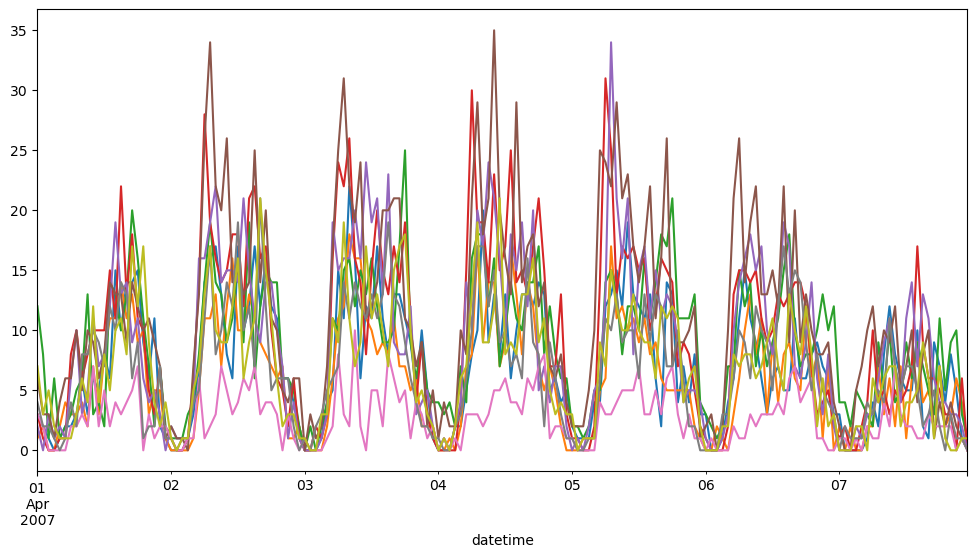

In [7]:
list_tiles = ['tile_' + j for j in ['557', '558', '559', '582', '583', '584', '602', '603', '604']]

fig, ax = plt.subplots(figsize = [12, 6])
df_ts[list_tiles].plot(ax = ax, legend = False);

# Time series segmentation

Applico una segmentazione spesso applicata nell'ambito del **Demand Forecasting** che consiste nel suddividere le serie storiche in 4 classi in base a due variabili di segmentazione:
 - **CV2** --> coefficiente di variabilità della serie, espresso come **dev_std / mu**, elevato al quadrato
 - **ADI** --> average demand interval --> quanto tempo mediamente intercorre tra due occorrenze diverse da 0 nella serie


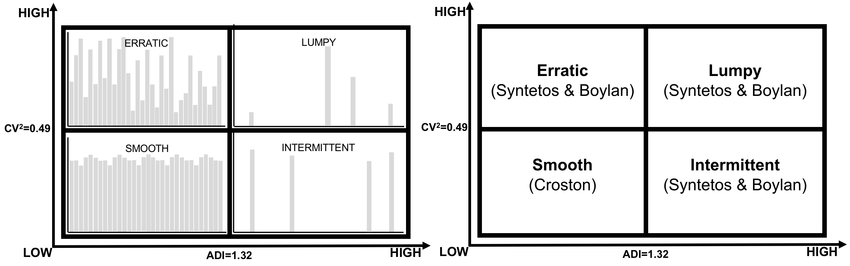

Le due soglie da letteratura in base alle quali segmentare sono:
- **ADI_thresh = 1.32**
- **CV2 = 0.49**

Per farlo mi appoggio allo script `ProjectWork_forecasting_functions` in cui è possibile trovare un po'di funzioni a supporto della segmentazione.

In [8]:
date_start = min(df_ts.index.to_list())
date_end = max(df_ts.index.to_list())
date_start, date_end

(Timestamp('2007-04-01 00:00:00'), Timestamp('2007-04-07 23:00:00'))

In [9]:
from ProjectWork_forecasting_functions import calc_stats, assign_segment


horizon, NZ_buckets, mu, std, ADI, CV, CV_squared = calc_stats( df_ts, date_start, date_end )

# Allineamento automatico secondo gli indici
df_segmentation = pd.concat([horizon, NZ_buckets, mu, std, ADI, CV, CV_squared], axis = 1)
print(df_segmentation.isnull().sum())

df_segmentation[df_segmentation['Std'].isnull()]

Horizon       0
NZ_buckets    0
Mean          0
Std           2
ADI           0
CV            2
CV2           2
dtype: int64


Horizon  NZ_buckets  Mean  Std    ADI  CV  CV2
tile_427      167           1   1.0  NaN  167.0 NaN  NaN
tile_401      167           1   1.0  NaN  167.0 NaN  NaN

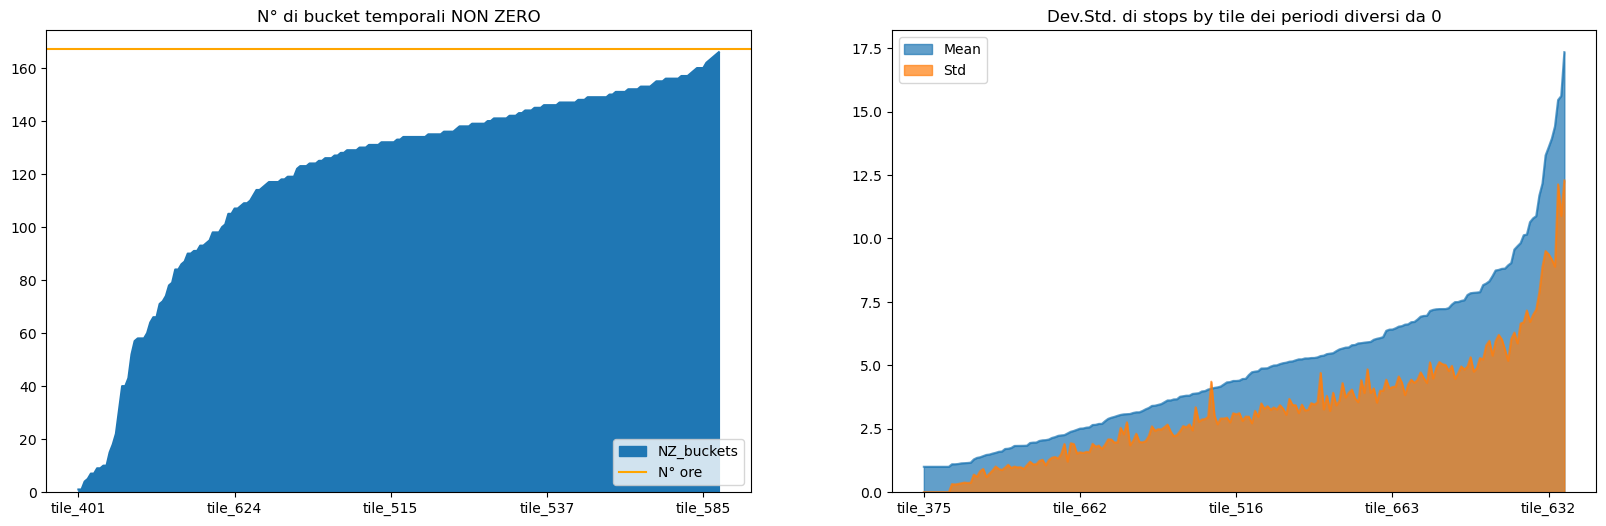

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))

df_segmentation['NZ_buckets'].sort_values().plot(kind = 'area', title = 'N° di bucket temporali NON ZERO', ax = ax[0])
ax[0].axhline(df_segmentation['Horizon'][0], c = 'orange', label = 'N° ore')
ax[0].legend()


idx = df_segmentation['Mean'].sort_values().index
df_segmentation.loc[idx, 'Mean'].plot(kind = 'area', title = 'Numero medio di stops by tile dei periodi diversi da 0', ax = ax[1], alpha = 0.7)
df_segmentation.loc[idx, 'Std'].plot(kind = 'area', title = 'Dev.Std. di stops by tile dei periodi diversi da 0', ax = ax[1], alpha = 0.7)
ax[1].legend();

In [11]:
# Elimino le tile che a seguito del calcolo hanno riportato dei NaN
df_segmentation.dropna(inplace = True)

df_segmentation['class'] = df_segmentation.apply(assign_segment, axis = 1)
df_segmentation.head()

Horizon  NZ_buckets       Mean        Std       ADI        CV  \
tile_664      167         157   7.216561   5.127001  1.063694  0.710449   
tile_624      167         107   2.457944   1.525138  1.560748  0.620493   
tile_665      167         129   4.162791   2.904175  1.294574  0.697651   
tile_644      167         115   3.400000   2.594867  1.452174  0.763196   
tile_387      167         166  17.343373  12.287325  1.006024  0.708474   

               CV2         class  
tile_664  0.504738       ERRATIC  
tile_624  0.385012  INTERMITTENT  
tile_665  0.486717        SMOOTH  
tile_644  0.582468         LUMPY  
tile_387  0.501935       ERRATIC

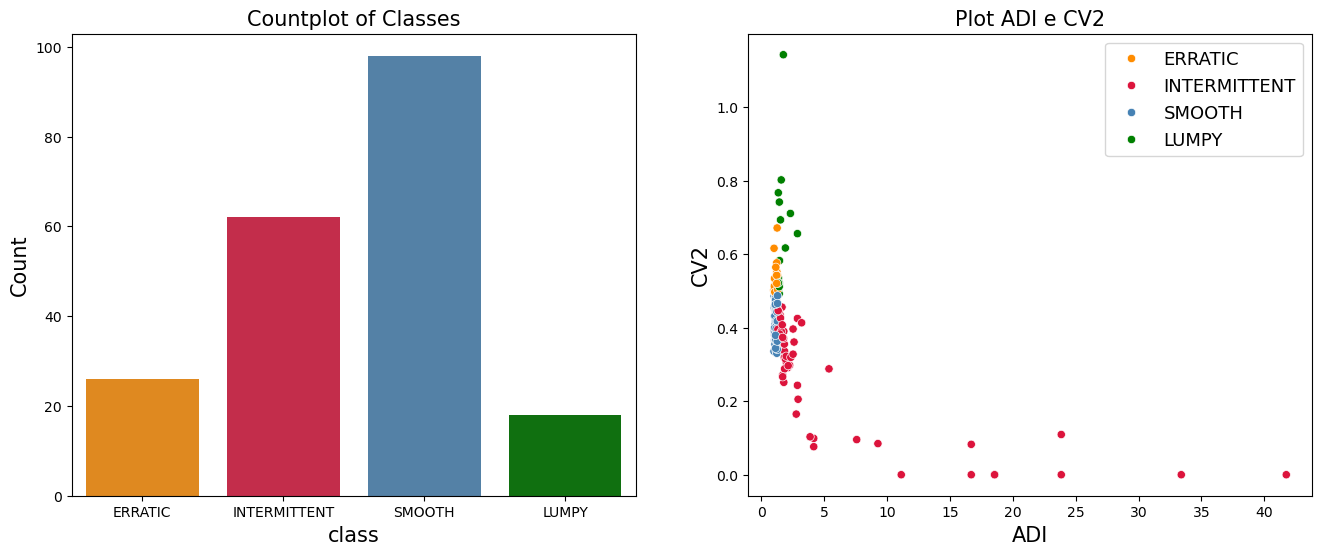

In [12]:
dict_color = {'SMOOTH': 'steelblue',
              'ERRATIC': 'darkorange',
              'INTERMITTENT': 'crimson',
              'LUMPY': 'green'}

fig, ax = plt.subplots(1,2, figsize = (16,6))

sns.countplot(x = df_segmentation['class'], ax = ax[0], palette = dict_color)
ax[0].set_title('Countplot of Classes', fontsize = 15)

sns.scatterplot(x = df_segmentation['ADI'],
                y = df_segmentation['CV2'], 
                hue = df_segmentation['class'], palette = dict_color, ax = ax[1])


ax[1].legend(facecolor = 'white', loc= 'upper right', fontsize = 13)
ax[1].set_title('Plot ADI e CV2', fontsize = 15)

ax[0].set_xlabel('class', fontsize = 15)
ax[0].set_ylabel('Count', fontsize = 15)
ax[1].set_xlabel('ADI', fontsize = 15)
ax[1].set_ylabel('CV2', fontsize = 15)
  
plt.show()

# Time Series Forecasting using ML

L'idea è derivare dataset da cui far apprendere algoritmi di machine learning, per addestrare il modello su `xlen` punti in fase di TRAINING e prevedere `ylen` punti nel futuro.

Questa operazione si esegue implementango un **meccanismo di lagging** che permette di ottenere delle **features con semantica temporale**.

Sfrutto la segmetazione precedentemente fatta per concentrarmi solo su una delle classi che abbiamo individuato. 

Solitamente la forecastability di una serie temporale aumenta quanto più il profilo di quella serie temporale vira verso un valore **SMOOTH**, pertanto cominciare con le serie temporali della classe **SMOOTH** potrebbe essere una buona soluzione.

In [13]:
list_tiles = df_segmentation[df_segmentation['class'] == 'SMOOTH'].index.to_list()
list_tiles[0:10]

['tile_665',
 'tile_673',
 'tile_670',
 'tile_634',
 'tile_583',
 'tile_610',
 'tile_598',
 'tile_403',
 'tile_628',
 'tile_501']

In [14]:
df_ts[list_tiles].T

datetime  2007-04-01 00:00:00  2007-04-01 01:00:00  2007-04-01 02:00:00  \
tile_665                  0.0                  1.0                  1.0   
tile_673                  9.0                  4.0                  5.0   
tile_670                  5.0                  1.0                  1.0   
tile_634                 12.0                  9.0                  4.0   
tile_583                  2.0                  0.0                  3.0   
...                       ...                  ...                  ...   
tile_653                  2.0                  0.0                  2.0   
tile_412                  2.0                  1.0                  0.0   
tile_465                  2.0                  3.0                  1.0   
tile_554                  1.0                  0.0                  0.0   
tile_490                  2.0                  2.0                  3.0   

datetime  2007-04-01 03:00:00  2007-04-01 04:00:00  2007-04-01 05:00:00  \
tile_665                  1.0                  0.0                  0.0   
tile_673                  4.0                  3.0                  4.0   
tile_670                  2.0                  0.0                  0.0   
tile_634                  2.0                  2.0                  6.0   
tile_583                  1.0                  2.0                  1.0   
...                       ...                  ...                  ...   
tile_653                  1.0                  0.0                  1.0   
tile_412                  1.0                  0.0                  0.0   
tile_465                  0.0                  0.0                  2.0   
tile_554                  1.0                  0.0                  1.0   
tile_490                  1.0                  1.0                  1.0   

datetime  2007-04-01 06:00:00  2007-04-01 07:00:00  2007-04-01 08:00:00  \
tile_665                  1.0                  3.0                  3.0   
tile_673                  9.0                 12.0                 15.0   
tile_670                  0.0                  2.0                  7.0   
tile_634                  6.0                  7.0                 12.0   
tile_583                  6.0                 10.0                  3.0   
...                       ...                  ...                  ...   
tile_653                  5.0                  3.0                  9.0   
tile_412                  2.0                  4.0                  6.0   
tile_465                  1.0                  5.0                  9.0   
tile_554                  1.0                  1.0                  1.0   
tile_490                  3.0                  5.0                  2.0   

datetime  2007-04-01 09:00:00  ...  2007-04-07 14:00:00  2007-04-07 15:00:00  \
tile_665                  8.0  ...                  3.0                  1.0   
tile_673                 21.0  ...                 11.0                 15.0   
tile_670                  5.0  ...                  4.0                  3.0   
tile_634                 10.0  ...                 17.0                  9.0   
tile_583                  5.0  ...                  7.0                 13.0   
...                       ...  ...                  ...                  ...   
tile_653                  7.0  ...                  1.0                  7.0   
tile_412                  5.0  ...                  0.0                  2.0   
tile_465                 13.0  ...                 11.0                 15.0   
tile_554                  0.0  ...                  1.0                  1.0   
tile_490                  6.0  ...                  3.0                  5.0   

datetime  2007-04-07 16:00:00  2007-04-07 17:00:00  2007-04-07 18:00:00  \
tile_665                  0.0                  1.0                  1.0   
tile_673                 12.0                  6.0                  4.0   
tile_670                  2.0                  0.0                  1.0   
tile_634                  8.0       

Per farlo mi appoggio allo script `ProjectWork_forecasting_functions` in cui è possibile trovare un po'di funzioni a supporto di:

- `create_dataframe` --> permette di creare gli `array X_train`, `y_train`, `X_test`, `y_test` che verranno usati in fase di **training** e **testing** degli algoritmi. Per la fase di test, è stato scelto un **orizzonte di backtesting di `test_loops` periodi

- `ML_forecast_KPI` --> permette di calcolare delle metriche che serviranno a valutare la forecast

- `aggregate_TRAIN` e `aggregate_TRAIN` --> consentono di riaggregare il vettore delle previsioni in un dataframe per poi fare la fase finale di ispezionamento dei risultati e grafici

- `make_plot_leaves` --> mi permette di efettuare i grafici


In [15]:
from ProjectWork_forecasting_functions import create_dataframe

# Utilizzo xlen periodi per prevederne ylen
# Il test set è composto da test_loops periodi
xlen, ylen, test_loops = 24, 1, 24
(X_train, y_train, X_test, y_test, feature_names) = create_dataframe(df_ts[list_tiles].T, 
                                                                     xlen = xlen,
                                                                     ylen = ylen,
                                                                     test_loops = test_loops)

1st fitted value on the training set :  2007-04-02 00:00:00
Last fitted value on the training set :  2007-04-06 23:00:00
1st predictable test period :  2007-04-07 00:00:00
Last predictable test period :  2007-04-07 23:00:00


In [16]:
# 1 riga per ogni TILE su cui voglio fare TRAIN / VAL / TEST
print(X_train.shape)
print(y_train.shape)
X_train, y_train

(11760, 26)
(11760, 1)


(array([[ 2.,  0.,  0., ...,  0.,  0.,  0.],
        [ 2.,  0.,  9., ...,  9.,  7.,  1.],
        [ 2.,  0.,  5., ...,  2.,  2.,  2.],
        ...,
        [ 6., 23.,  4., ...,  6.,  3.,  2.],
        [ 6., 23.,  2., ...,  1.,  0.,  1.],
        [ 6., 23.,  0., ...,  1.,  4.,  1.]]),
 array([[0.],
        [5.],
        [0.],
        ...,
        [4.],
        [1.],
        [3.]]))

In [17]:
# 1 riga per ogni TILE su cui voglio fare TRAIN / VAL / TEST

print(X_test.shape)
print(y_test.shape)
X_test, y_test

(2352, 26)
(2352, 1)


(array([[ 7.,  0.,  0., ...,  0.,  0.,  1.],
        [ 7.,  0.,  4., ...,  7.,  3.,  2.],
        [ 7.,  0.,  0., ...,  2.,  0.,  1.],
        ...,
        [ 7., 23.,  4., ...,  4.,  0.,  0.],
        [ 7., 23.,  1., ...,  1.,  0.,  0.],
        [ 7., 23.,  3., ...,  2.,  1.,  0.]]),
 array([[1.],
        [1.],
        [3.],
        ...,
        [0.],
        [0.],
        [0.]]))

## Cross validation of time series data (from Documentation)
Time series data is characterized by the correlation between observations that are near in time (autocorrelation). However, classical cross-validation techniques such as KFold and ShuffleSplit assume the samples are independent and identically distributed, and would result in unreasonable correlation between training and testing instances (yielding poor estimates of generalization error) on time series data. Therefore, it is very important to evaluate our model for time series data on the “future” observations least like those that are used to train the model. To achieve this, one solution is provided by TimeSeriesSplit.

`TimeSeriesSplit` is a **variation of k-fold** which returns **first folds as train set** and the **th-fold as test set**. Note that unlike standard cross-validation methods, **successive training sets are supersets of those that come before** them. Also, it adds **all surplus data to the first training partition**, which is always used to train the model.

This class can be used to cross-validate time series data samples that are observed at fixed time intervals. Example of 3-split time series cross-validation on a dataset with 6 samples:

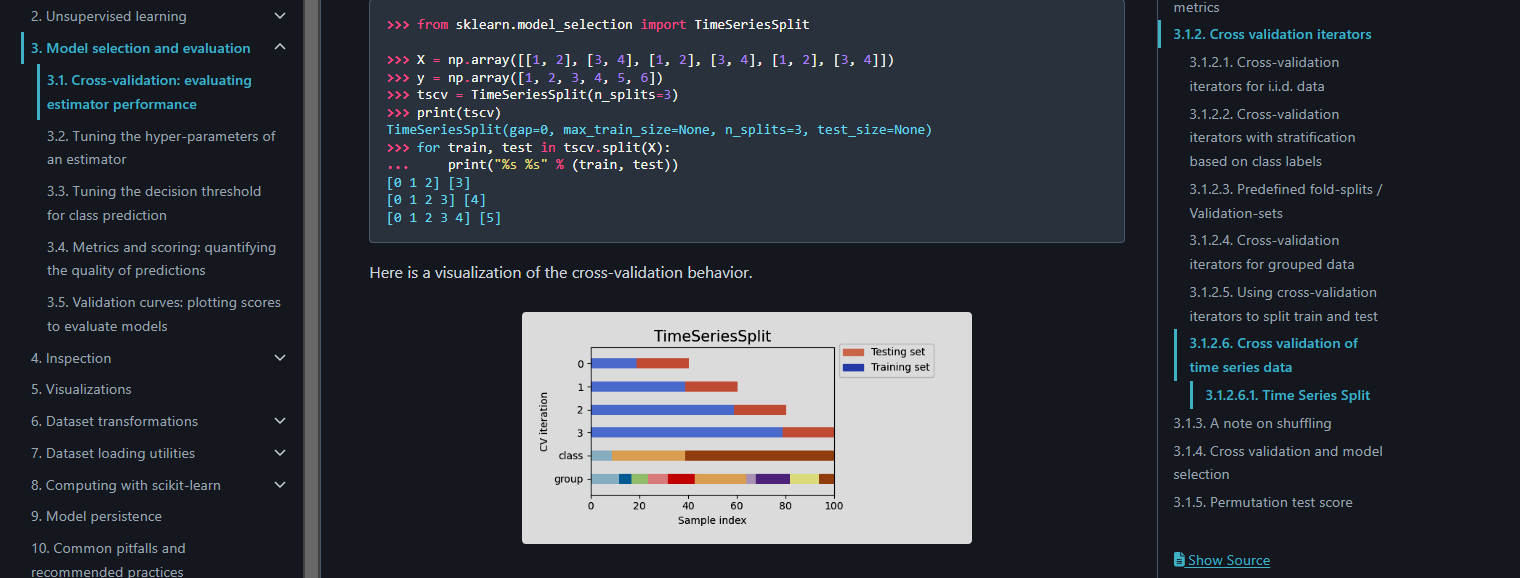


In [18]:
from sklearn.model_selection import TimeSeriesSplit


# Creazione dell'oggetto TimeSeriesSplit
#tscv = TimeSeriesSplit(n_splits = 5)
tscv = TimeSeriesSplit(n_splits = 3, test_size = 2)
#tscv = TimeSeriesSplit(n_splits = 3, test_size = 2, gap = 2)

proof_X = np.random.rand(15, 6).round(1)
proof_y = np.random.rand(15, 1).round(1)

print(proof_X)
print(proof_y)
print('\n\nLook at the split:\n')

for train, val in tscv.split(proof_X):
    print( '%s\n%s' % (train, proof_X[train]) )
    print('\n')
    print( '%s\n%s' % (val, proof_X[val]) )
    print(30*'=')

[[1.  0.9 0.1 0.2 0.9 0.7]
 [0.2 0.2 0.2 0.6 1.  0.1]
 [0.2 0.9 0.5 0.4 0.1 0.1]
 [0.1 0.2 0.6 0.4 0.5 0.1]
 [0.9 0.4 0.9 0.4 0.7 1. ]
 [1.  0.1 0.6 0.  0.8 0.9]
 [1.  0.1 0.6 0.2 0.  0.9]
 [0.8 0.2 0.3 0.5 0.3 0.5]
 [0.7 0.2 1.  0.5 0.1 0.9]
 [0.2 0.5 0.6 0.8 1.  0.6]
 [0.1 0.4 0.6 0.9 0.3 0.7]
 [0.7 0.3 0.4 0.2 0.6 0.7]
 [0.8 0.3 0.9 0.5 0.8 0.5]
 [0.4 0.6 0.5 0.7 0.4 0.9]
 [0.7 0.4 0.  0.2 1.  0.7]]
[[0.7]
 [0.4]
 [0.2]
 [0. ]
 [0.1]
 [0.1]
 [0.4]
 [0.3]
 [0.6]
 [0.3]
 [0.7]
 [0.1]
 [0.6]
 [0.7]
 [0.8]]


Look at the split:

[0 1 2 3 4 5 6 7 8]
[[1.  0.9 0.1 0.2 0.9 0.7]
 [0.2 0.2 0.2 0.6 1.  0.1]
 [0.2 0.9 0.5 0.4 0.1 0.1]
 [0.1 0.2 0.6 0.4 0.5 0.1]
 [0.9 0.4 0.9 0.4 0.7 1. ]
 [1.  0.1 0.6 0.  0.8 0.9]
 [1.  0.1 0.6 0.2 0.  0.9]
 [0.8 0.2 0.3 0.5 0.3 0.5]
 [0.7 0.2 1.  0.5 0.1 0.9]]


[ 9 10]
[[0.2 0.5 0.6 0.8 1.  0.6]
 [0.1 0.4 0.6 0.9 0.3 0.7]]
[ 0  1  2  3  4  5  6  7  8  9 10]
[[1.  0.9 0.1 0.2 0.9 0.7]
 [0.2 0.2 0.2 0.6 1.  0.1]
 [0.2 0.9 0.5 0.4 0.1 0.1]
 [0.1 0.2 0.6 0.4 0.5

Dagli esperimenti di cui sopra si capisce che:
- `test_size` è il numero di forecasting units, quindi di **Tiles** che vado a forecastare insieme
- `n_splits` è essenzialmente pari al numero di validations che deve avere la CV

Ad esempio: ho un dataset con K forecasting units, uno storico di T periodi e voglio usare `xlen periodi di storico` per `prevedere ylen periodi`.

In tutto il dataframe X che ottengo avrò un numero di `loops` pari a: `loops = T - xlen - ylen + 1`. Allo stesso modo il dataframe X che ottengo avrà il seguente numero di righe: `K * (T - xlen - ylen + 1)`.

Quindi se voglio efettuare una CV ordinata temporalmente devo mettere:
- `test_size = K`
- `n_splits` tale che valga: `loops - ylen * splits = 1` ovvero `K * (T - xlen - ylen + 1) - K * n_splits * ylen = K`

Quindi nel mio caso specifico:

In [19]:
K = df_ts[list_tiles].T.shape[0]
T = df_ts[list_tiles].T.shape[1] - test_loops # numero totale di periodi su cui fare la TSCV
print(xlen, ylen)

loops = T - xlen - ylen + 1
#n_splits = int((loops - xlen) / ylen)
n_splits = int((loops - 1) / ylen)

tscv = TimeSeriesSplit(n_splits = n_splits, test_size = K)

cnt = 1
for train, val in tscv.split(X_train):
    print( 'Ciclo di validation %s - TRAIN su %s dataset' % (cnt, X_train[train].shape))
    print( 'Ciclo di validation %s - VALID su %s dataset' % (cnt, X_train[val].shape))
    print(50*'=')
    cnt += 1

24 1
Ciclo di validation 1 - TRAIN su (98, 26) dataset
Ciclo di validation 1 - VALID su (98, 26) dataset
Ciclo di validation 2 - TRAIN su (196, 26) dataset
Ciclo di validation 2 - VALID su (98, 26) dataset
Ciclo di validation 3 - TRAIN su (294, 26) dataset
Ciclo di validation 3 - VALID su (98, 26) dataset
Ciclo di validation 4 - TRAIN su (392, 26) dataset
Ciclo di validation 4 - VALID su (98, 26) dataset
Ciclo di validation 5 - TRAIN su (490, 26) dataset
Ciclo di validation 5 - VALID su (98, 26) dataset
Ciclo di validation 6 - TRAIN su (588, 26) dataset
Ciclo di validation 6 - VALID su (98, 26) dataset
Ciclo di validation 7 - TRAIN su (686, 26) dataset
Ciclo di validation 7 - VALID su (98, 26) dataset
Ciclo di validation 8 - TRAIN su (784, 26) dataset
Ciclo di validation 8 - VALID su (98, 26) dataset
Ciclo di validation 9 - TRAIN su (882, 26) dataset
Ciclo di validation 9 - VALID su (98, 26) dataset
Ciclo di validation 10 - TRAIN su (980, 26) dataset
Ciclo di validation 10 - VALID su (

## 1) Time Series Forecasting using ML: Random Forest

### Training - Validation

L'obiettivo di questa sezione è di trainare un modello di ML in cross validation seguendo la sequenza temporale dei timestamp.

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

model_type = 'RandomForest'

model = RandomForestRegressor(criterion = 'squared_error', bootstrap = True, n_estimators = 10, n_jobs = 2)

dist = {'max_depth' : range(5, 25, 3),
        'min_samples_split' : range(8, 100, 10),
        'min_samples_leaf' : range(3, 15, 1),
        'max_features': range(10, 120, 10),
        'max_samples': [0.7, 0.85, 0.95, 1]}

model = RandomizedSearchCV(model, # lo stimatore scelto
                           param_distributions = dist, # la distribuzione dei parametri da testare
                           scoring = 'neg_root_mean_squared_error', # lo score in base a cui ottimizzare i parametri
                           cv = tscv, # Fold della Cross Validation
                           verbose = 1, # 1, 2, o 3 a secoda di quanto vuoi che scriva man mano che testa
                           n_iter = 50, # numero di iterazioni considerate
                           refit = True, # refittare lo stimatore in base alla migliore combinazione di parametri testata
                           return_train_score = True)

bool_train = False

if bool_train:
        # Fitting del modello migliore scelto con la Randomized Cross Validation
        model.fit(X_train, y_train)
        
        # Salvare il modello in formato pickle
        with open(f'{model_type}.pkl', 'wb') as file:
                pickle.dump(model, file)
else:
        # Caricare il modello dal file pickle
        with open(f'{model_type}.pkl', 'rb') as file:
                model = pickle.load(file)
        
        
print(f'\nParametri della migliore istanza di {model_type}:\n', model.best_params_)


Parametri della migliore istanza di RandomForest:
 {'min_samples_split': 18, 'min_samples_leaf': 3, 'max_samples': 0.85, 'max_features': 10, 'max_depth': 23}


### CV results

Plotto i risultati della **cross validation** in cui è stato mantenuto l'ordinamento temporale dei record.

In [21]:
cv_results = model.cv_results_

# Creazione di un DataFrame dai risultati della cross-validation
df_cv_results = pd.DataFrame(cv_results)
df_cv_results.index = pd.Series(df_cv_results.index).apply(lambda x: 'grid_' + str(x))
df_cv_results = df_cv_results.sort_values( by = 'mean_test_score', ascending = False)

# Salvo il risultato  su file
directory = os.getcwd()
os.makedirs(directory, exist_ok = True)

# Salvo il risultato su un excel per vederlo
file_id = f'{model_type}_CV_results.xlsx'
path = os.path.join(directory, file_id)
df_cv_results.to_excel(path) 

In [22]:
df_cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
grid_48       0.309094      0.113485         0.026934        0.007854   
grid_31       0.302623      0.179120         0.020796        0.006773   
grid_33       0.285456      0.179560         0.021459        0.007066   
grid_23       0.132372      0.065959         0.019689        0.006312   
grid_17       0.374126      0.177468         0.023810        0.007988   

        param_min_samples_split param_min_samples_leaf param_max_samples  \
grid_48                      18                      3              0.85   
grid_31                       8                      5               0.7   
grid_33                      18                      6              0.85   
grid_23                       8                     12              0.85   
grid_17                       8                     10              0.85   

        param_max_features param_max_depth  \
grid_48                 10              23   
grid_31                 50              23   
grid_33                 80              17   
grid_23                 20               8   
grid_17                 50              23   

                                                    params  ...  \
grid_48  {'min_samples_split': 18, 'min_samples_leaf': ...  ...   
grid_31  {'min_samples_split': 8, 'min_samples_leaf': 5...  ...   
grid_33  {'min_samples_split': 18, 'min_samples_leaf': ...  ...   
grid_23  {'min_samples_split': 8, 'min_samples_leaf': 1...  ...   
grid_17  {'min_samples_split': 8, 'min_samples_leaf': 1...  ...   

         split111_train_score  split112_train_score  split113_train_score  \
grid_48             -2.205641             -2.218890             -2.242219   
grid_31             -2.107697             -2.106749             -2.128029   
grid_33             -2.232491             -2.237022             -2.255805   
grid_23             -2.668786             -2.690157             -2.677356   
grid_17             -2.381230             -2.394276             -2.378422   

         split114_train_score  split115_train_score  split116_train_score  \
grid_48             -2.227920             -2.239368             -2.218895   
grid_31             -2.119365             -2.123032             -2.124518   
grid_33             -2.258094             -2.253791             -2.232306   
grid_23             -2.692058             -2.683663             -2.687572   
grid_17             -2.377406             -2.380205             -2.371842   

         split117_train_score  split118_train_score  mean_train_score  \
grid_48             -2.207160             -2.227544         -2.250720   
grid_31             -2.115581             -2.101494         -2.137843   
grid_33             -2.243741             -2.240195         -2.264145   
grid_23             -2.668292             -2.651728         -2.636344   
grid_17             -2.361971             -2.358477         -2.400392   

         std_train_score  
grid_48         0.324870  
grid_31         0.301761  
grid_33         0.322156  
grid_23         0.385433  
grid_17         0.341842  

[5 rows x 253 columns]

Visualizzo i risultati della cross validation ordinati per migliore **media delle metriche di errore sul validation set**.

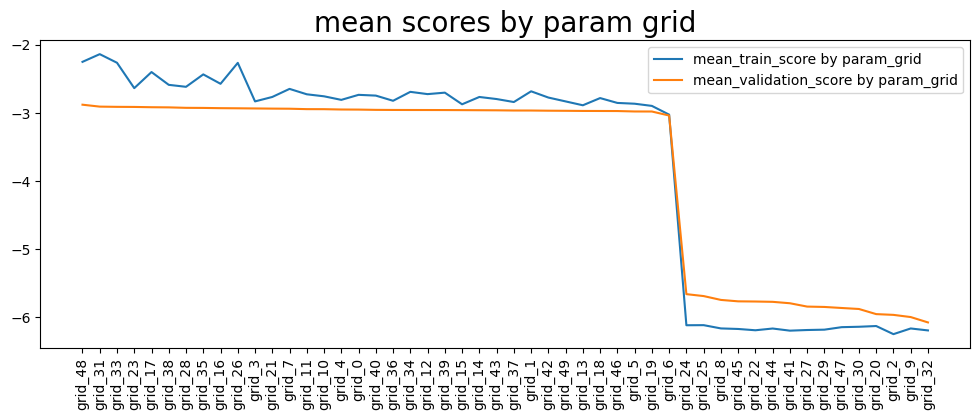

In [23]:
fig, ax = plt.subplots(figsize = (12, 4))
df_cv_results['mean_train_score'].plot(label = 'mean_train_score by param_grid', ax = ax)
df_cv_results['mean_test_score'].plot(label = 'mean_validation_score by param_grid', ax = ax)

# Set x-axis ticks to show all index values
ax.set_xticks(range(len(df_cv_results['mean_test_score'])))
# Set x-axis tick labels to show the index values and rotate them by 45 degrees
ax.set_xticklabels(df_cv_results.index, rotation = 90)

ax.set_title('mean scores by param grid',fontsize = 20)
plt.legend();

Prendiamo le **migliori grid** di training e validation e vediamo come è variato il suo score attraverso i **cicli di train - validate**:

In [24]:
top = 10

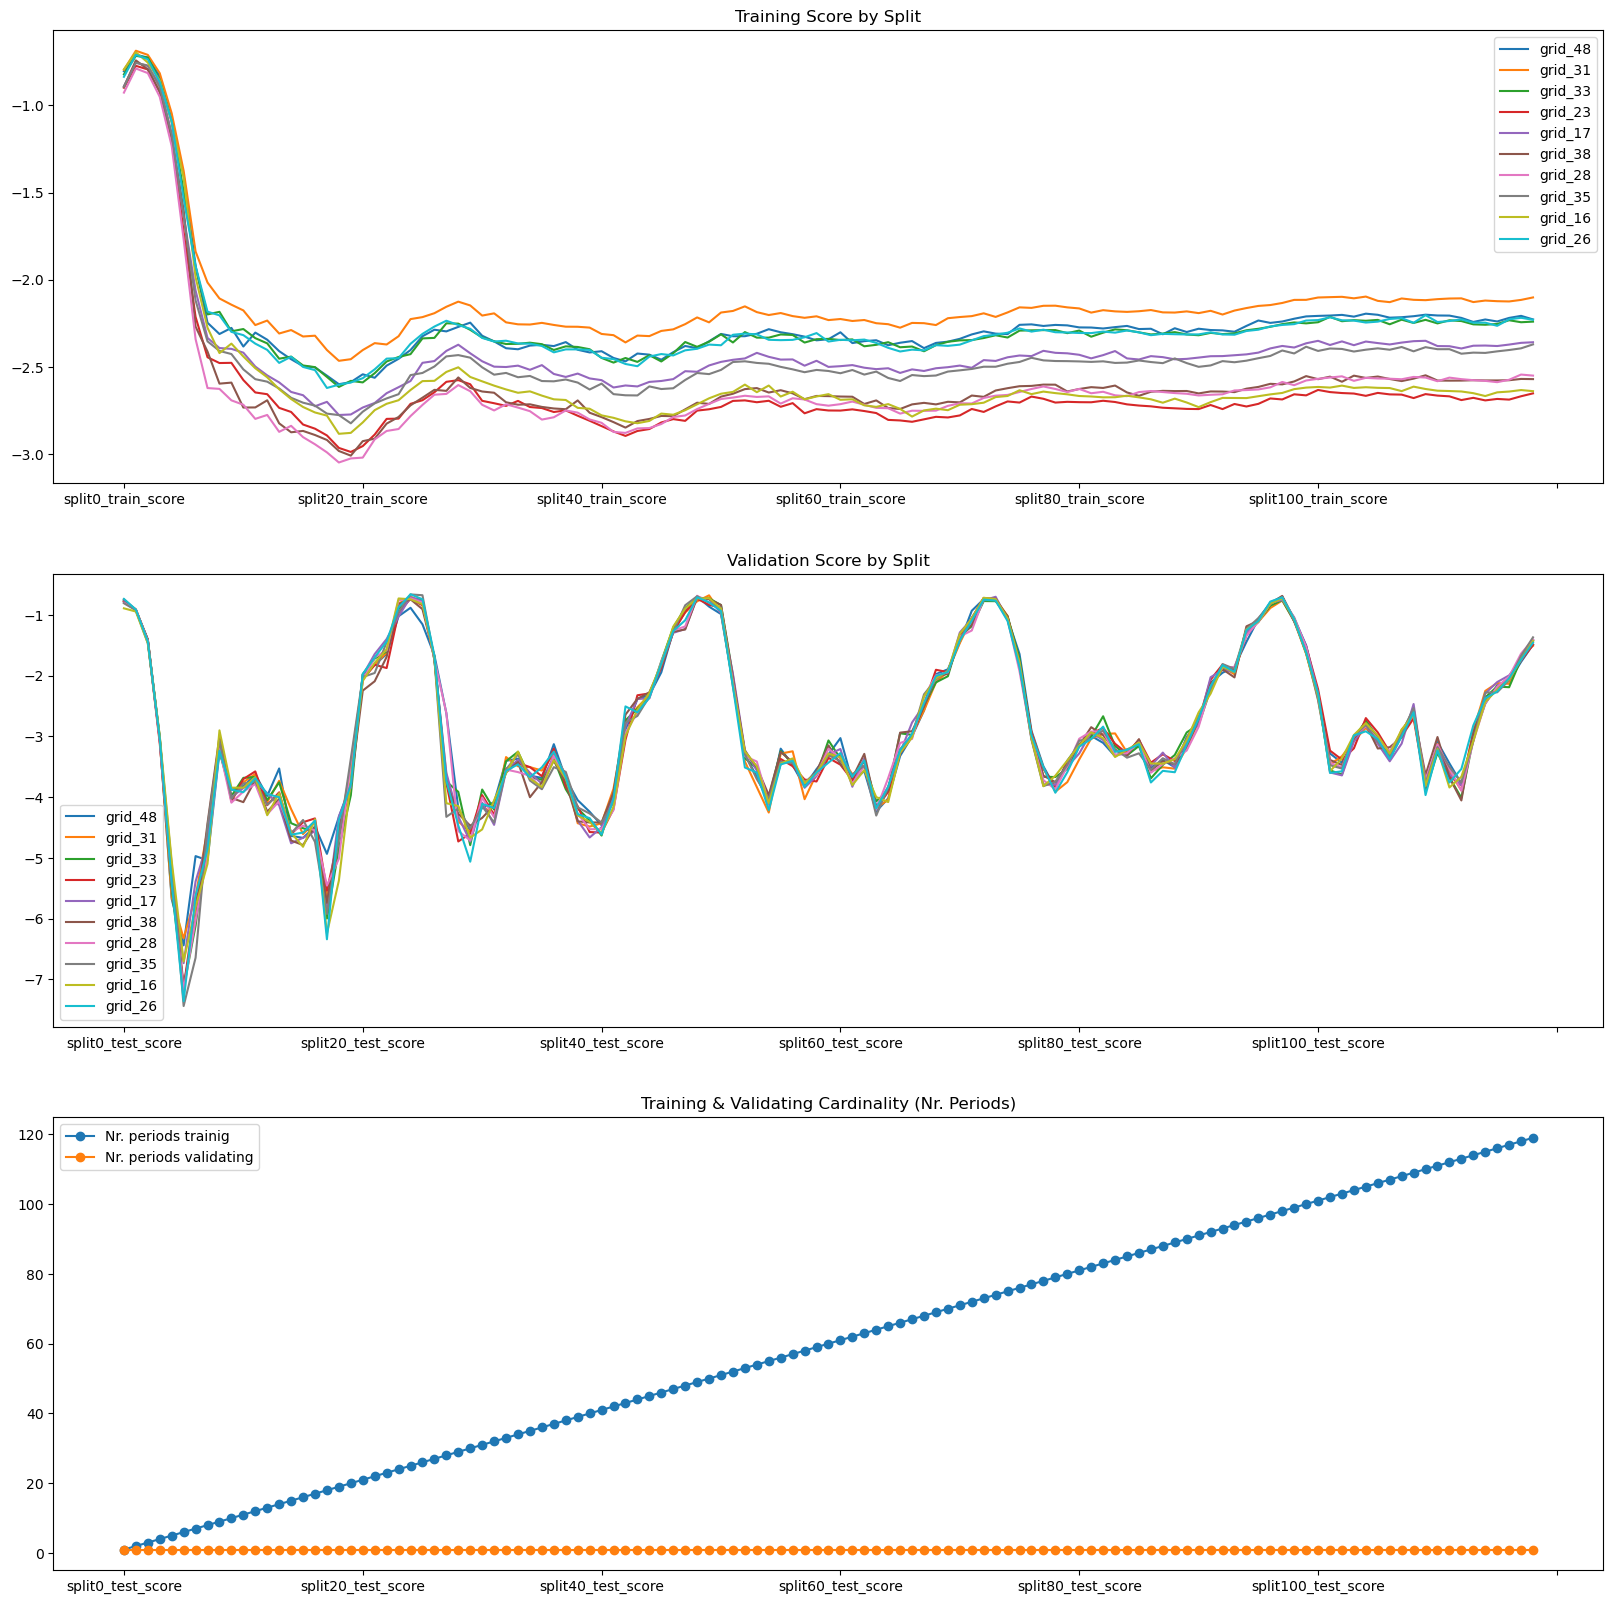

In [25]:
# ============================================================================================
# Estraggo gli split di training e di validation

split_train = [col for col in df_cv_results.columns if 'split' in col and 'train' in col]
split_valid = [col for col in df_cv_results.columns if 'split' in col and 'test' in col]

# ============================================================================================
# Calcolo le dimensioni del training set e del validation set man mano che la TS-CV va avanti
dim_train = []
dim_valid = []

for train, valid in tscv.split(X_train):
    dim_train.append(train.shape[0] / K)
    dim_valid.append(valid.shape[0] / K)

dim_train = pd.Series(dim_train, index = split_train)
dim_valid = pd.Series(dim_valid, index = split_valid)

# ============================================================================================

fig, ax = plt.subplots(3, 1, figsize = (20, 20))

df_cv_results[split_train].head(top).T.plot(label = 'training set score by split' , ax = ax[0], title = 'Training Score by Split')
df_cv_results[split_valid].head(top).T.plot(label = 'validation set score by split' , ax = ax[1], title = 'Validation Score by Split')
dim_train.plot(label = 'Nr. periods trainig', ax = ax[2], title = 'Training & Validating Cardinality (Nr. Periods)', marker = 'o')
dim_valid.plot(label = 'Nr. periods validating', ax = ax[2], marker = 'o')


#ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 90)
#ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 90)

ax[0].legend();
ax[1].legend();
ax[2].legend();

In [26]:
df_cv_results[split_train].head(top).T

grid_48   grid_31   grid_33   grid_23   grid_17  \
split0_train_score   -0.804053 -0.795875 -0.821935 -0.898789 -0.890323   
split1_train_score   -0.709739 -0.686387 -0.715884 -0.772975 -0.754719   
split2_train_score   -0.725301 -0.710184 -0.725996 -0.793699 -0.774240   
split3_train_score   -0.833293 -0.815475 -0.854808 -0.921958 -0.880848   
split4_train_score   -1.083340 -1.045212 -1.093303 -1.185343 -1.162308   
...                        ...       ...       ...       ...       ...   
split114_train_score -2.227920 -2.119365 -2.258094 -2.692058 -2.377406   
split115_train_score -2.239368 -2.123032 -2.253791 -2.683663 -2.380205   
split116_train_score -2.218895 -2.124518 -2.232306 -2.687572 -2.371842   
split117_train_score -2.207160 -2.115581 -2.243741 -2.668292 -2.361971   
split118_train_score -2.227544 -2.101494 -2.240195 -2.651728 -2.358477   

                       grid_38   grid_28   grid_35   grid_16   grid_26  
split0_train_score   -0.894199 -0.926675 -0.892274 -0.793034 -0.835922  
split1_train_score   -0.741608 -0.788384 -0.755486 -0.695213 -0.709681  
split2_train_score   -0.793391 -0.814753 -0.771289 -0.754189 -0.735187  
split3_train_score   -0.923892 -0.950947 -0.895907 -0.856152 -0.867046  
split4_train_score   -1.189526 -1.232813 -1.167156 -1.095375 -1.091174  
...                        ...       ...       ...       ...       ...  
split114_train_score -2.577556 -2.580050 -2.419733 -2.667049 -2.246089  
split115_train_score -2.577553 -2.587509 -2.410742 -2.645885 -2.264314  
split116_train_score -2.576382 -2.573689 -2.403036 -2.641289 -2.227017  
split117_train_score -2.568964 -2.543832 -2.393388 -2.632708 -2.218286  
split118_train_score -2.569959 -2.549856 -2.370772 -2.639067 -2.229624  

[119 rows x 10 columns]

In [27]:
df_cv_results[split_valid].head(top).T

grid_48   grid_31   grid_33   grid_23   grid_17  \
split0_test_score   -0.784893 -0.781328 -0.767067 -0.774949 -0.756658   
split1_test_score   -0.919391 -0.907487 -0.920405 -0.922133 -0.911700   
split2_test_score   -1.406882 -1.415374 -1.420462 -1.421087 -1.434702   
split3_test_score   -3.058820 -3.065810 -3.003588 -3.113010 -3.044929   
split4_test_score   -5.678717 -5.648568 -5.499833 -5.413482 -5.303452   
...                       ...       ...       ...       ...       ...   
split114_test_score -2.462832 -2.252051 -2.358878 -2.440464 -2.293240   
split115_test_score -2.160688 -2.122592 -2.180106 -2.190891 -2.106218   
split116_test_score -2.090185 -2.135486 -2.190776 -2.035225 -1.995665   
split117_test_score -1.773880 -1.660314 -1.728551 -1.751399 -1.743932   
split118_test_score -1.488353 -1.508443 -1.432508 -1.493672 -1.408526   

                      grid_38   grid_28   grid_35   grid_16   grid_26  
split0_test_score   -0.745196 -0.800405 -0.808435 -0.891795 -0.737115  
split1_test_score   -0.923412 -0.914420 -0.923165 -0.945088 -0.912100  
split2_test_score   -1.403009 -1.427202 -1.466594 -1.464002 -1.436997  
split3_test_score   -3.032352 -3.072924 -3.034004 -2.993330 -3.030052  
split4_test_score   -5.253837 -5.385026 -5.109770 -5.050894 -5.413666  
...                       ...       ...       ...       ...       ...  
split114_test_score -2.406239 -2.457167 -2.278211 -2.434751 -2.374066  
split115_test_score -2.207199 -2.182717 -2.274642 -2.231561 -2.260985  
split116_test_score -2.056027 -2.015066 -2.074689 -2.060762 -2.042147  
split117_test_score -1.720009 -1.637307 -1.673684 -1.734608 -1.736014  
split118_test_score -1.425349 -1.407310 -1.369448 -1.428324 -1.458393  

[119 rows x 10 columns]

### Inference

In questa sezione vengono approfondite le previsioni con il modello sopra addestrato:

In [28]:
#%% PREDICTION SUL TRAIN per VEDERE COME FITTA IL MODELLO

# Predizione sul TRAIN
y_train_pred = model.predict(X_train) # per visualizzare modello fittato su X_train, y_train

# Faccio il reshaping perché alcuni algoritmi nel fare la previsione di un solo periodo, ritornano un 1d-array
# mentre il mio script è impostato per funzionare su 2d-array anche se il numero di colonne è 1
y_train_pred = y_train_pred.reshape(-1, 1)

# Predizione sul TEST
y_pred = model.predict(X_test)

# I valori negativi li metto a 0
y_pred[ y_pred <= 0 ] = 0
y_train_pred[ y_train_pred <= 0 ] = 0
 
# Faccio il reshaping perché alcuni algoritmi nel fare la previsione di un solo periodo, ritornano un 1d-array
# mentre il mio script è impostato per funzionare su 2d-array anche se il numero di colonne è 1
y_pred = y_pred.reshape(-1, 1)

from ProjectWork_forecasting_functions import ML_forecast_KPI

for j in range(ylen):
    df_kpi = ML_forecast_KPI(y_train[:, j], y_train_pred[:, j], y_test[:, j], y_pred[:, j])
    df_kpi['forecasting_period'] = j+1
    print('\nForecasting Period #', j+1)
    print(df_kpi)


Forecasting Period # 1
         MAE%   RMSE%   BIAS%     R^2  forecasting_period
Train  0.2395  0.3405 -0.0019  0.8548                   1
Test   0.7329  0.9602 -0.5207  0.4100                   1


In [29]:
y_train[0:5]

array([[0.],
       [5.],
       [0.],
       [2.],
       [2.]])

In [30]:
y_train_pred[0:5]

array([[0.14619827],
       [5.57434066],
       [1.0403854 ],
       [6.02073558],
       [1.0909478 ]])

In [31]:
y_test[0:5]

array([[1.],
       [1.],
       [3.],
       [2.],
       [0.]])

In [32]:
y_pred[0:5]

array([[0.23762493],
       [1.80189232],
       [0.30839379],
       [1.27141522],
       [0.64451116]])

### Feature Importance

Visualizziamo la **features importance** nel modello sopra selezionato:

In [33]:
def plot_features_importance(scores, names):
    
    # Ordino in base agli scores
    order = np.argsort(scores)[::-1]
    scores_ordered = scores[order]
    names_ordered = names[order]
        

    fig, ax = plt.subplots(1, 2, figsize = (18, 8))
    ax[0].barh(names_ordered[::-1], scores_ordered[::-1], 
            color = 'black')
    ax[1].plot(names_ordered, np.cumsum(scores_ordered),
            color = 'black', marker = 'o', markersize = 4)
    ax[1].tick_params(rotation = 90)

    fig.suptitle('Features Importance', fontsize = 20)
    plt.show()
    
feature_scores = np.array(model.best_estimator_.feature_importances_)
print(feature_scores)

plot_features_importance

[0.01608465 0.07246814 0.25674955 0.17670118 0.0503122  0.00896574
 0.0088517  0.00632108 0.00656236 0.00706612 0.00551137 0.00529066
 0.00803078 0.0064324  0.00561366 0.00842734 0.00886213 0.00756928
 0.00586918 0.01049716 0.00630182 0.00728175 0.00950343 0.01138975
 0.03754478 0.24579179]


<function __main__.plot_features_importance(scores, names)>

Di seguito possiamo **riaggregare il risultato da forma vettoriale a dataframe**

In [34]:
#%% Riaggregare y_train e y_train_pred in un dataset => df_y_train & df_y_train_pred

from ProjectWork_forecasting_functions import aggregate_TRAIN, aggregate_TEST

# Scegli quale periodo futuro che è stato precedentemente predetto analizzare
t = 0

# Aggregazione di y_train in df_y_train
df_y_train = aggregate_TRAIN(array_TRAIN = y_train, 
                             A = df_ts[list_tiles].T, 
                             xlen = xlen, ylen = ylen, test_loops = test_loops, 
                             t = t)

# Aggregazione di y_train_pred in df_y_train_pred
df_y_train_pred = aggregate_TRAIN(array_TRAIN = y_train_pred, 
                                  A = df_ts[list_tiles].T, 
                                  xlen = xlen, ylen = ylen, test_loops = test_loops, 
                                  t = t)

#%% Riaggregare TEST e PREVISIONE in dei dataset => df_y_test e df_y_pred
df_y_test =  aggregate_TEST(array_TEST = y_test, 
                            A = df_ts[list_tiles].T, 
                            xlen = xlen, ylen = ylen, test_loops = test_loops, 
                            t = t, 
                            how = 'test',
                            future_cols = ['2024.03', '2024.04', '2024.05'])

df_y_pred =  aggregate_TEST(array_TEST = y_pred, 
                            A = df_ts[list_tiles].T, 
                            xlen = xlen, ylen = ylen, test_loops = test_loops, 
                            t = t,
                            how = 'pred',
                            future_cols = ['2024.03', '2024.04', '2024.05'])

In [35]:
df_y_train.head()

datetime  2007-04-02 00:00:00  2007-04-02 01:00:00  2007-04-02 02:00:00  \
tile_665                  0.0                  2.0                  0.0   
tile_673                  5.0                  0.0                  4.0   
tile_670                  0.0                  0.0                  0.0   
tile_634                  2.0                  0.0                  0.0   
tile_583                  2.0                  1.0                  1.0   

datetime  2007-04-02 03:00:00  2007-04-02 04:00:00  2007-04-02 05:00:00  \
tile_665                  1.0                  4.0                  2.0   
tile_673                  2.0                 11.0                 24.0   
tile_670                  3.0                  0.0                  5.0   
tile_634                  0.0                 11.0                 24.0   
tile_583                  1.0                  4.0                 16.0   

datetime  2007-04-02 06:00:00  2007-04-02 07:00:00  2007-04-02 08:00:00  \
tile_665                 10.0                 11.0                  5.0   
tile_673                 34.0                 29.0                 27.0   
tile_670                  6.0                  7.0                 11.0   
tile_634                 38.0                 31.0                 31.0   
tile_583                 16.0                 19.0                 22.0   

datetime  2007-04-02 09:00:00  ...  2007-04-06 14:00:00  2007-04-06 15:00:00  \
tile_665                  3.0  ...                  7.0                  2.0   
tile_673                 23.0  ...                  9.0                 18.0   
tile_670                  9.0  ...                  8.0                  5.0   
tile_634                 17.0  ...                 20.0                 21.0   
tile_583                 14.0  ...                 19.0                 17.0   

datetime  2007-04-06 16:00:00  2007-04-06 17:00:00  2007-04-06 18:00:00  \
tile_665                  3.0                  4.0                  0.0   
tile_673                 21.0                 19.0                 16.0   
tile_670                  3.0                  8.0                  3.0   
tile_634                 16.0                  9.0                 16.0   
tile_583                  7.0                  6.0                  9.0   

datetime  2007-04-06 19:00:00  2007-04-06 20:00:00  2007-04-06 21:00:00  \
tile_665                  2.0                  0.0                  0.0   
tile_673                  9.0                  6.0                  7.0   
tile_670                  5.0                  5.0                  2.0   
tile_634                 10.0                  5.0                 11.0   
tile_583                 14.0                  6.0                  3.0   

datetime  2007-04-06 22:00:00  2007-04-06 23:00:00  
tile_665                  0.0                  1.0  
tile_673                  3.0                  2.0  
tile_670                  0.0                  1.0  
tile_634                  4.0                  2.0  
tile_583                  8.0                  2.0  

[5 rows x 120 columns]

In [36]:
df_y_train_pred.head()

datetime  2007-04-02 00:00:00  2007-04-02 01:00:00  2007-04-02 02:00:00  \
tile_665             0.146198             0.546779             0.700344   
tile_673             5.574341             2.244697             2.877813   
tile_670             1.040385             0.029167             0.915459   
tile_634             6.020736             2.780401             1.083274   
tile_583             1.090948             0.632875             0.775403   

datetime  2007-04-02 03:00:00  2007-04-02 04:00:00  2007-04-02 05:00:00  \
tile_665             0.654575             2.168239             4.942377   
tile_673             2.826370             7.891710            19.110206   
tile_670             0.776008             1.580143             3.674231   
tile_634             0.734260             3.872035            17.515920   
tile_583             1.057023             3.465197            10.758431   

datetime  2007-04-02 06:00:00  2007-04-02 07:00:00  2007-04-02 08:00:00  \
tile_665             6.892287             6.681221             7.401238   
tile_673            24.442834            21.168194            22.143532   
tile_670             6.643516             7.590414             8.991099   
tile_634            23.158550            20.157491            21.583939   
tile_583            14.738653            17.096310            14.340162   

datetime  2007-04-02 09:00:00  ...  2007-04-06 14:00:00  2007-04-06 15:00:00  \
tile_665             5.729178  ...             5.140258             5.246970   
tile_673            22.278866  ...            17.042497            20.735037   
tile_670             7.742176  ...             6.439517             6.275136   
tile_634            20.864699  ...            18.271105            20.554393   
tile_583            14.606504  ...            14.320057            15.509854   

datetime  2007-04-06 16:00:00  2007-04-06 17:00:00  2007-04-06 18:00:00  \
tile_665             6.619837             4.639702             2.798053   
tile_673            20.465231            20.697723            15.571883   
tile_670             5.719912             5.408416             5.194009   
tile_634            19.671699            17.075427            12.834334   
tile_583            11.789603             9.554374             9.941825   

datetime  2007-04-06 19:00:00  2007-04-06 20:00:00  2007-04-06 21:00:00  \
tile_665             1.965084             1.158069             1.030165   
tile_673            11.085103             7.958326             7.752672   
tile_670             3.824675             2.780396             2.242369   
tile_634             9.656260             7.643761             6.755539   
tile_583            10.384883             6.772606             4.361161   

datetime  2007-04-06 22:00:00  2007-04-06 23:00:00  
tile_665             0.794837             1.333915  
tile_673             4.284590             3.350822  
tile_670             1.072846             1.071769  
tile_634             3.991930             2.743876  
tile_583             4.529432             3.978302  

[5 rows x 120 columns]

In [37]:
df_y_test.head()

datetime  2007-04-07 00:00:00  2007-04-07 01:00:00  2007-04-07 02:00:00  \
tile_665                  1.0                  0.0                  0.0   
tile_673                  1.0                  2.0                  4.0   
tile_670                  3.0                  0.0                  1.0   
tile_634                  2.0                  4.0                  0.0   
tile_583                  0.0                  0.0                  0.0   

datetime  2007-04-07 03:00:00  2007-04-07 04:00:00  2007-04-07 05:00:00  \
tile_665                  0.0                  0.0                  3.0   
tile_673                  4.0                  0.0                  4.0   
tile_670                  0.0                  0.0                  1.0   
tile_634                  2.0                  5.0                  3.0   
tile_583                  2.0                  1.0                  3.0   

datetime  2007-04-07 06:00:00  2007-04-07 07:00:00  2007-04-07 08:00:00  \
tile_665                  0.0                  2.0                  2.0   
tile_673                  9.0                  8.0                 12.0   
tile_670                  5.0                  4.0                  2.0   
tile_634                  9.0                  9.0                 15.0   
tile_583                  3.0                  6.0                  9.0   

datetime  2007-04-07 09:00:00  ...  2007-04-07 14:00:00  2007-04-07 15:00:00  \
tile_665                  3.0  ...                  3.0                  1.0   
tile_673                 17.0  ...                 11.0                 15.0   
tile_670                  7.0  ...                  4.0                  3.0   
tile_634                  8.0  ...                 17.0                  9.0   
tile_583                 11.0  ...                  7.0                 13.0   

datetime  2007-04-07 16:00:00  2007-04-07 17:00:00  2007-04-07 18:00:00  \
tile_665                  0.0                  1.0                  1.0   
tile_673                 12.0                  6.0                  4.0   
tile_670                  2.0                  0.0                  1.0   
tile_634                  8.0                  7.0                  5.0   
tile_583                 11.0                  6.0                  4.0   

datetime  2007-04-07 19:00:00  2007-04-07 20:00:00  2007-04-07 21:00:00  \
tile_665                  2.0                  0.0                  0.0   
tile_673                  1.0                  4.0                  2.0   
tile_670                  1.0                  1.0                  0.0   
tile_634                  5.0                  4.0                  3.0   
tile_583                  4.0                  3.0                  3.0   

datetime  2007-04-07 22:00:00  2007-04-07 23:00:00  
tile_665                  0.0                  0.0  
tile_673                  1.0                  0.0  
tile_670                  0.0                  0.0  
tile_634                  0.0                  0.0  
tile_583                  2.0                  0.0  

[5 rows x 24 columns]

In [38]:
df_y_pred.head()

datetime  2007-04-07 00:00:00  2007-04-07 01:00:00  2007-04-07 02:00:00  \
tile_665             0.237625             0.497984             0.789138   
tile_673             1.801892             1.472452             1.676461   
tile_670             0.308394             0.908303             0.254068   
tile_634             1.271415             0.836072             4.074445   
tile_583             0.644511             0.576412             0.380919   

datetime  2007-04-07 03:00:00  2007-04-07 04:00:00  2007-04-07 05:00:00  \
tile_665             1.008013             1.743872             3.884676   
tile_673             4.844476             7.757290            17.099358   
tile_670             0.981190             1.853534             4.415139   
tile_634             2.710120             6.956091            12.874089   
tile_583             1.274391             3.186884             8.860851   

datetime  2007-04-07 06:00:00  2007-04-07 07:00:00  2007-04-07 08:00:00  \
tile_665             3.536788             2.629661             2.959428   
tile_673            15.083838            14.073877            14.270307   
tile_670             5.824002             6.829189             4.624373   
tile_634            13.648634            11.582940            11.014190   
tile_583            13.543786            12.369249            12.913904   

datetime  2007-04-07 09:00:00  ...  2007-04-07 14:00:00  2007-04-07 15:00:00  \
tile_665             3.054437  ...             3.767830             2.992604   
tile_673            18.988360  ...            13.834278            14.066762   
tile_670             4.836833  ...             4.314137             4.569238   
tile_634            13.797089  ...            14.317718            16.188142   
tile_583            11.271571  ...            12.075449            10.142452   

datetime  2007-04-07 16:00:00  2007-04-07 17:00:00  2007-04-07 18:00:00  \
tile_665             2.157353             2.543718             1.846108   
tile_673            16.131427            16.928005            11.927198   
tile_670             3.947494             4.666518             2.638668   
tile_634            11.456214            10.401310            11.244428   
tile_583             8.744276            10.575114             8.260489   

datetime  2007-04-07 19:00:00  2007-04-07 20:00:00  2007-04-07 21:00:00  \
tile_665             1.695203             1.482945             1.628427   
tile_673             7.231094             5.666858             3.738931   
tile_670             4.705082             2.915615             1.276846   
tile_634             7.844905             4.512571             6.473326   
tile_583             8.235020             6.328527             4.064875   

datetime  2007-04-07 22:00:00  2007-04-07 23:00:00  
tile_665             1.374628             1.647945  
tile_673             1.720675             2.064376  
tile_670             1.248871             1.557662  
tile_634             3.813217             1.943283  
tile_583             3.344293             1.242114  

[5 rows x 24 columns]

### Calcolo dataframe di errore

Calcolo adesso gli errori per ogni tile_ID:

In [39]:
df_error_train = df_y_train_pred - df_y_train
df_error_train.head()

datetime  2007-04-02 00:00:00  2007-04-02 01:00:00  2007-04-02 02:00:00  \
tile_665             0.146198            -1.453221             0.700344   
tile_673             0.574341             2.244697            -1.122187   
tile_670             1.040385             0.029167             0.915459   
tile_634             4.020736             2.780401             1.083274   
tile_583            -0.909052            -0.367125            -0.224597   

datetime  2007-04-02 03:00:00  2007-04-02 04:00:00  2007-04-02 05:00:00  \
tile_665            -0.345425            -1.831761             2.942377   
tile_673             0.826370            -3.108290            -4.889794   
tile_670            -2.223992             1.580143            -1.325769   
tile_634             0.734260            -7.127965            -6.484080   
tile_583             0.057023            -0.534803            -5.241569   

datetime  2007-04-02 06:00:00  2007-04-02 07:00:00  2007-04-02 08:00:00  \
tile_665            -3.107713            -4.318779             2.401238   
tile_673            -9.557166            -7.831806            -4.856468   
tile_670             0.643516             0.590414            -2.008901   
tile_634           -14.841450           -10.842509            -9.416061   
tile_583            -1.261347            -1.903690            -7.659838   

datetime  2007-04-02 09:00:00  ...  2007-04-06 14:00:00  2007-04-06 15:00:00  \
tile_665             2.729178  ...            -1.859742             3.246970   
tile_673            -0.721134  ...             8.042497             2.735037   
tile_670            -1.257824  ...            -1.560483             1.275136   
tile_634             3.864699  ...            -1.728895            -0.445607   
tile_583             0.606504  ...            -4.679943            -1.490146   

datetime  2007-04-06 16:00:00  2007-04-06 17:00:00  2007-04-06 18:00:00  \
tile_665             3.619837             0.639702             2.798053   
tile_673            -0.534769             1.697723            -0.428117   
tile_670             2.719912            -2.591584             2.194009   
tile_634             3.671699             8.075427            -3.165666   
tile_583             4.789603             3.554374             0.941825   

datetime  2007-04-06 19:00:00  2007-04-06 20:00:00  2007-04-06 21:00:00  \
tile_665            -0.034916             1.158069             1.030165   
tile_673             2.085103             1.958326             0.752672   
tile_670            -1.175325            -2.219604             0.242369   
tile_634            -0.343740             2.643761            -4.244461   
tile_583            -3.615117             0.772606             1.361161   

datetime  2007-04-06 22:00:00  2007-04-06 23:00:00  
tile_665             0.794837             0.333915  
tile_673             1.284590             1.350822  
tile_670             1.072846             0.071769  
tile_634            -0.008070             0.743876  
tile_583            -3.470568             1.978302  

[5 rows x 120 columns]

In [40]:
df_error_test = df_y_pred - df_y_test
df_error_test.head()

datetime  2007-04-07 00:00:00  2007-04-07 01:00:00  2007-04-07 02:00:00  \
tile_665            -0.762375             0.497984             0.789138   
tile_673             0.801892            -0.527548            -2.323539   
tile_670            -2.691606             0.908303            -0.745932   
tile_634            -0.728585            -3.163928             4.074445   
tile_583             0.644511             0.576412             0.380919   

datetime  2007-04-07 03:00:00  2007-04-07 04:00:00  2007-04-07 05:00:00  \
tile_665             1.008013             1.743872             0.884676   
tile_673             0.844476             7.757290            13.099358   
tile_670             0.981190             1.853534             3.415139   
tile_634             0.710120             1.956091             9.874089   
tile_583            -0.725609             2.186884             5.860851   

datetime  2007-04-07 06:00:00  2007-04-07 07:00:00  2007-04-07 08:00:00  \
tile_665             3.536788             0.629661             0.959428   
tile_673             6.083838             6.073877             2.270307   
tile_670             0.824002             2.829189             2.624373   
tile_634             4.648634             2.582940            -3.985810   
tile_583            10.543786             6.369249             3.913904   

datetime  2007-04-07 09:00:00  ...  2007-04-07 14:00:00  2007-04-07 15:00:00  \
tile_665             0.054437  ...             0.767830             1.992604   
tile_673             1.988360  ...             2.834278            -0.933238   
tile_670            -2.163167  ...             0.314137             1.569238   
tile_634             5.797089  ...            -2.682282             7.188142   
tile_583             0.271571  ...             5.075449            -2.857548   

datetime  2007-04-07 16:00:00  2007-04-07 17:00:00  2007-04-07 18:00:00  \
tile_665             2.157353             1.543718             0.846108   
tile_673             4.131427            10.928005             7.927198   
tile_670             1.947494             4.666518             1.638668   
tile_634             3.456214             3.401310             6.244428   
tile_583            -2.255724             4.575114             4.260489   

datetime  2007-04-07 19:00:00  2007-04-07 20:00:00  2007-04-07 21:00:00  \
tile_665            -0.304797             1.482945             1.628427   
tile_673             6.231094             1.666858             1.738931   
tile_670             3.705082             1.915615             1.276846   
tile_634             2.844905             0.512571             3.473326   
tile_583             4.235020             3.328527             1.064875   

datetime  2007-04-07 22:00:00  2007-04-07 23:00:00  
tile_665             1.374628             1.647945  
tile_673             0.720675             2.064376  
tile_670             1.248871             1.557662  
tile_634             3.813217             1.943283  
tile_583             1.344293             1.242114  

[5 rows x 24 columns]

Visualizzo i parametri principali degli errori per ogni tile_ID in termini di **media** e **deviaziona standard**.

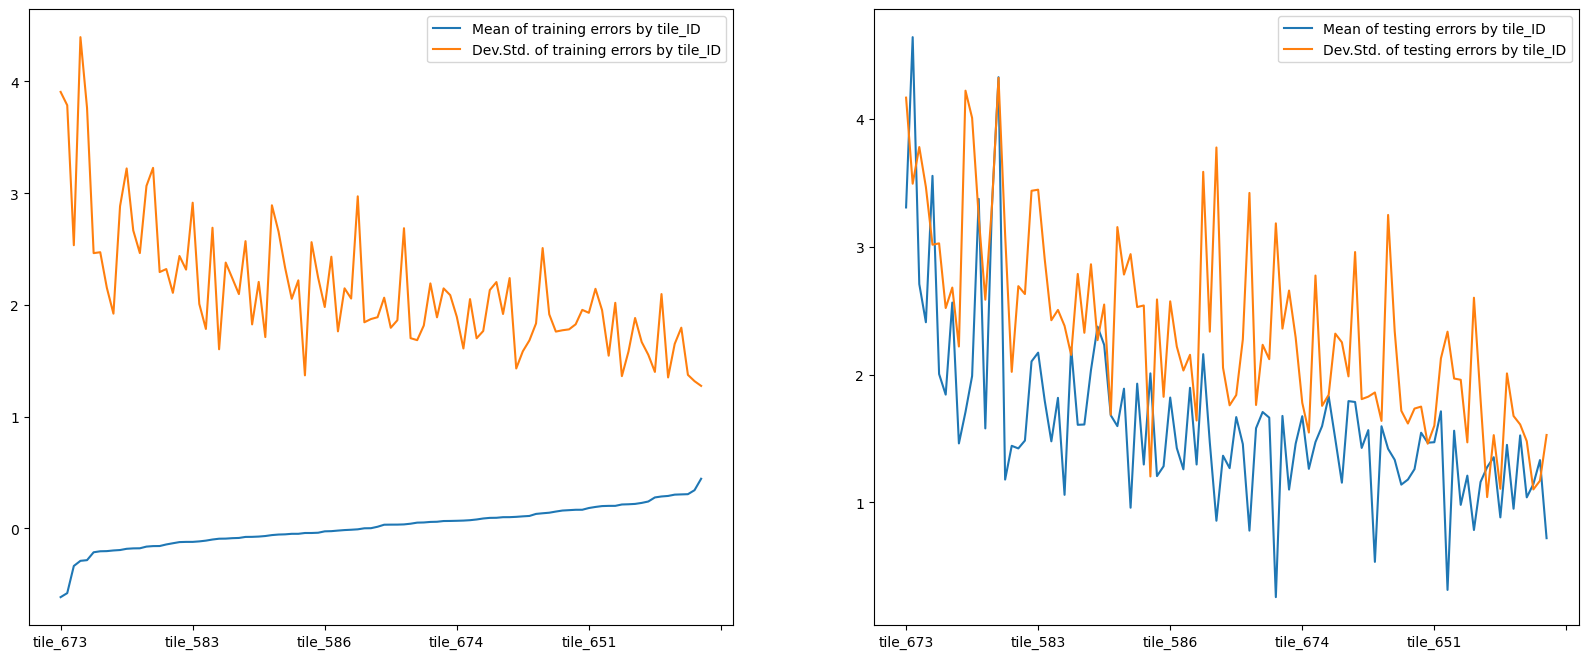

In [41]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))

mean_error_train = df_error_train.mean(axis = 1)
sd_error_train = df_error_train.std(axis = 1)
mean_error_test = df_error_test.mean(axis = 1)
sd_error_test = df_error_test.std(axis = 1)

idx = mean_error_train.sort_values().index


mean_error_train[idx].plot(label = 'Mean of training errors by tile_ID', ax = ax[0])
sd_error_train[idx].plot(label = 'Dev.Std. of training errors by tile_ID', ax = ax[0])

mean_error_test[idx].plot(label = 'Mean of testing errors by tile_ID', ax = ax[1])
sd_error_test[idx].plot(label = 'Dev.Std. of testing errors by tile_ID', ax = ax[1])

ax[0].legend()
ax[1].legend();

### Data Viz

Di seguito si osserva il risultato graficamente:

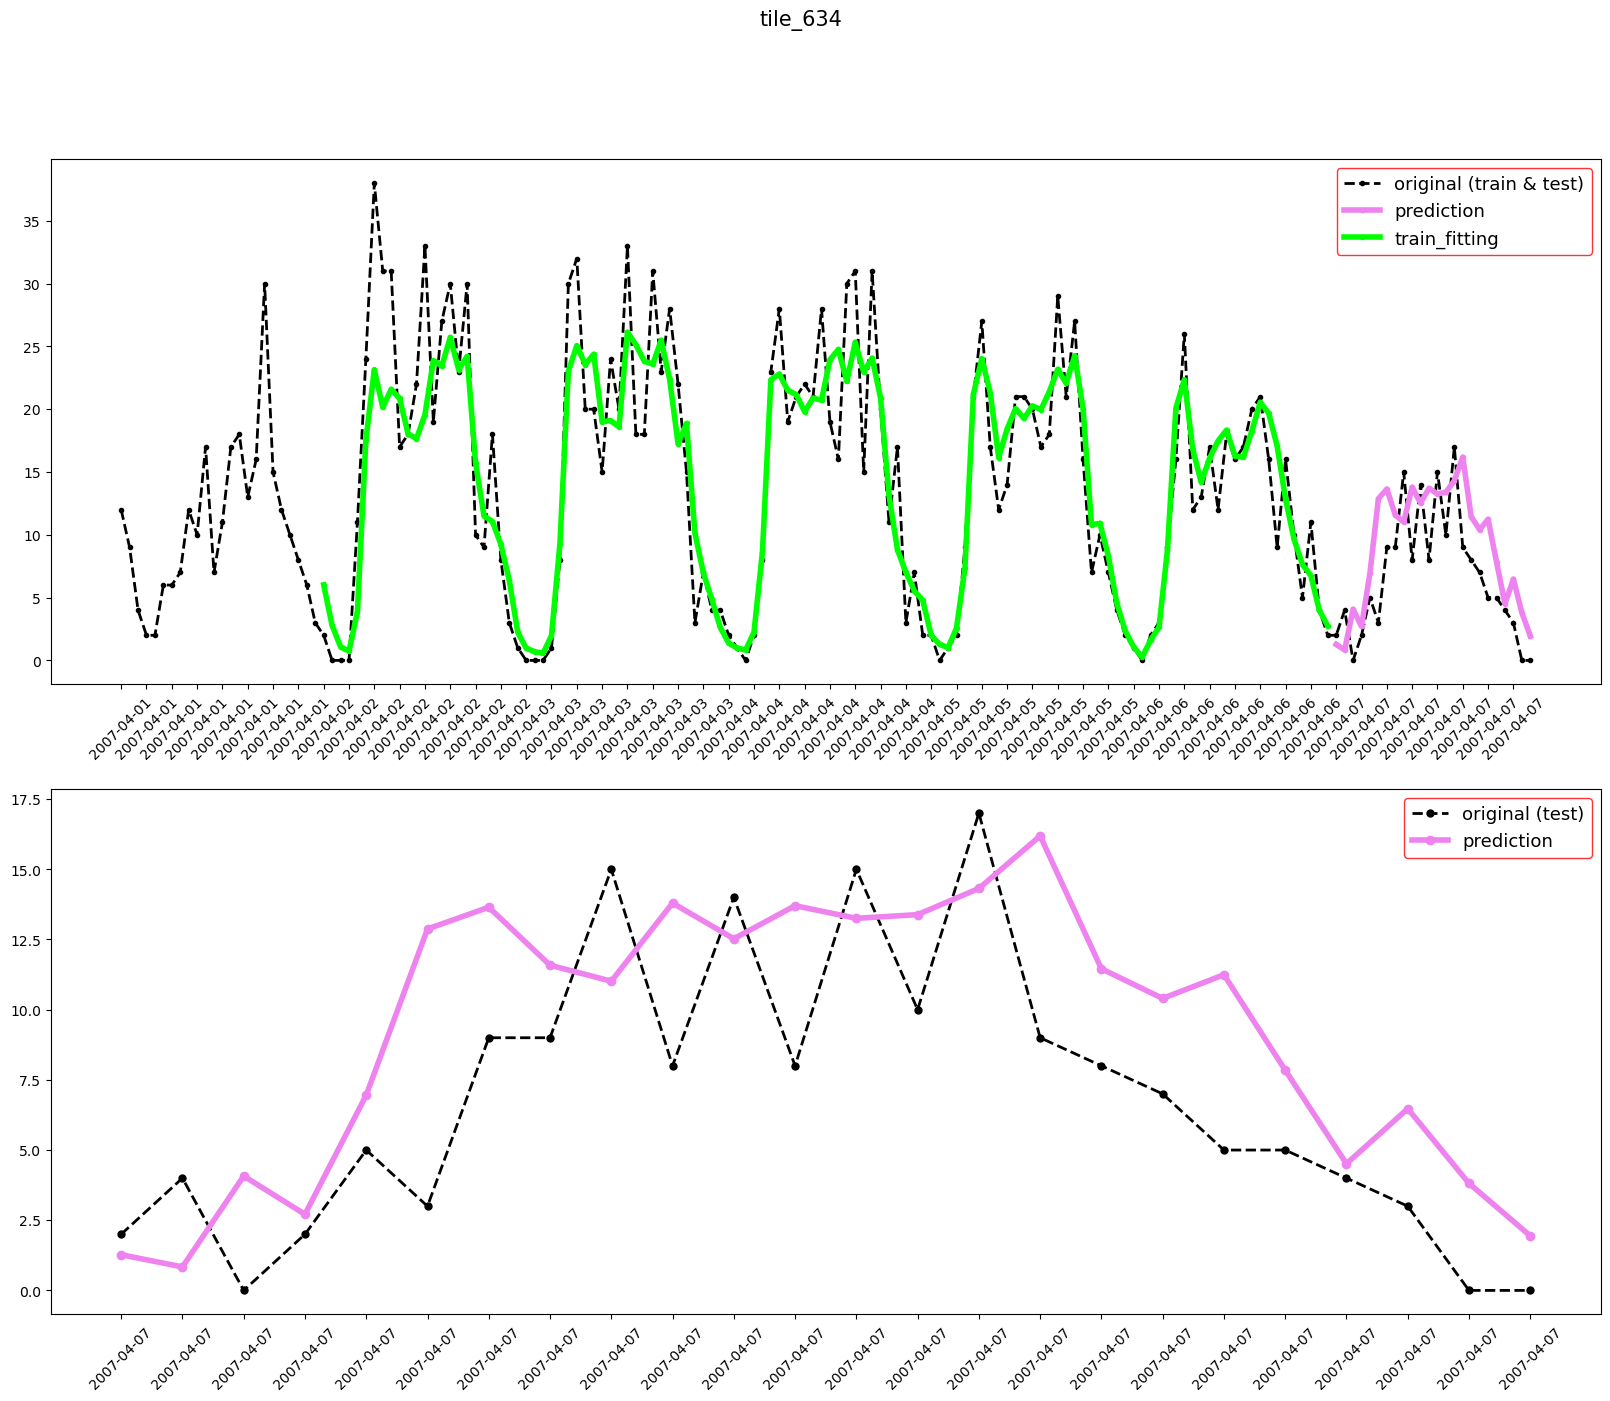

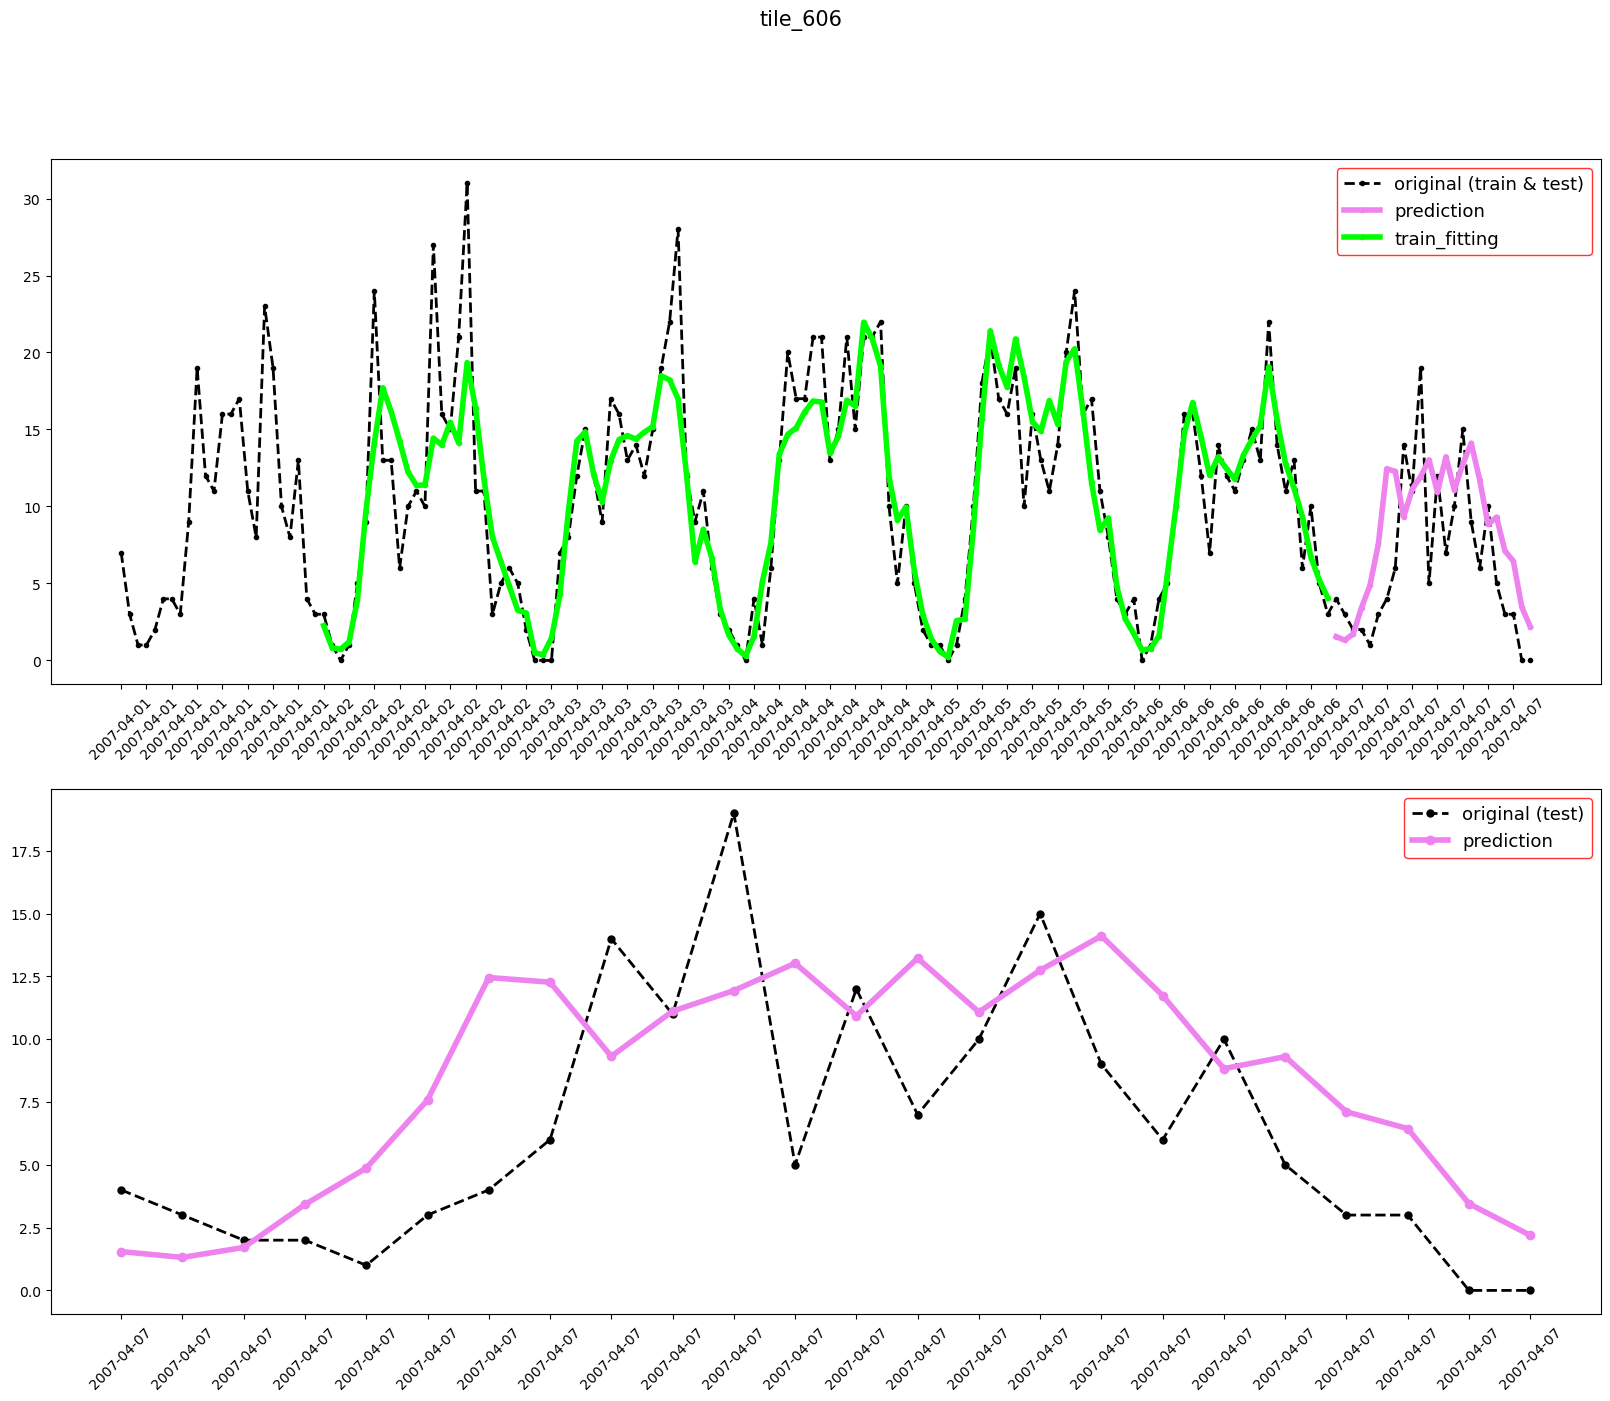

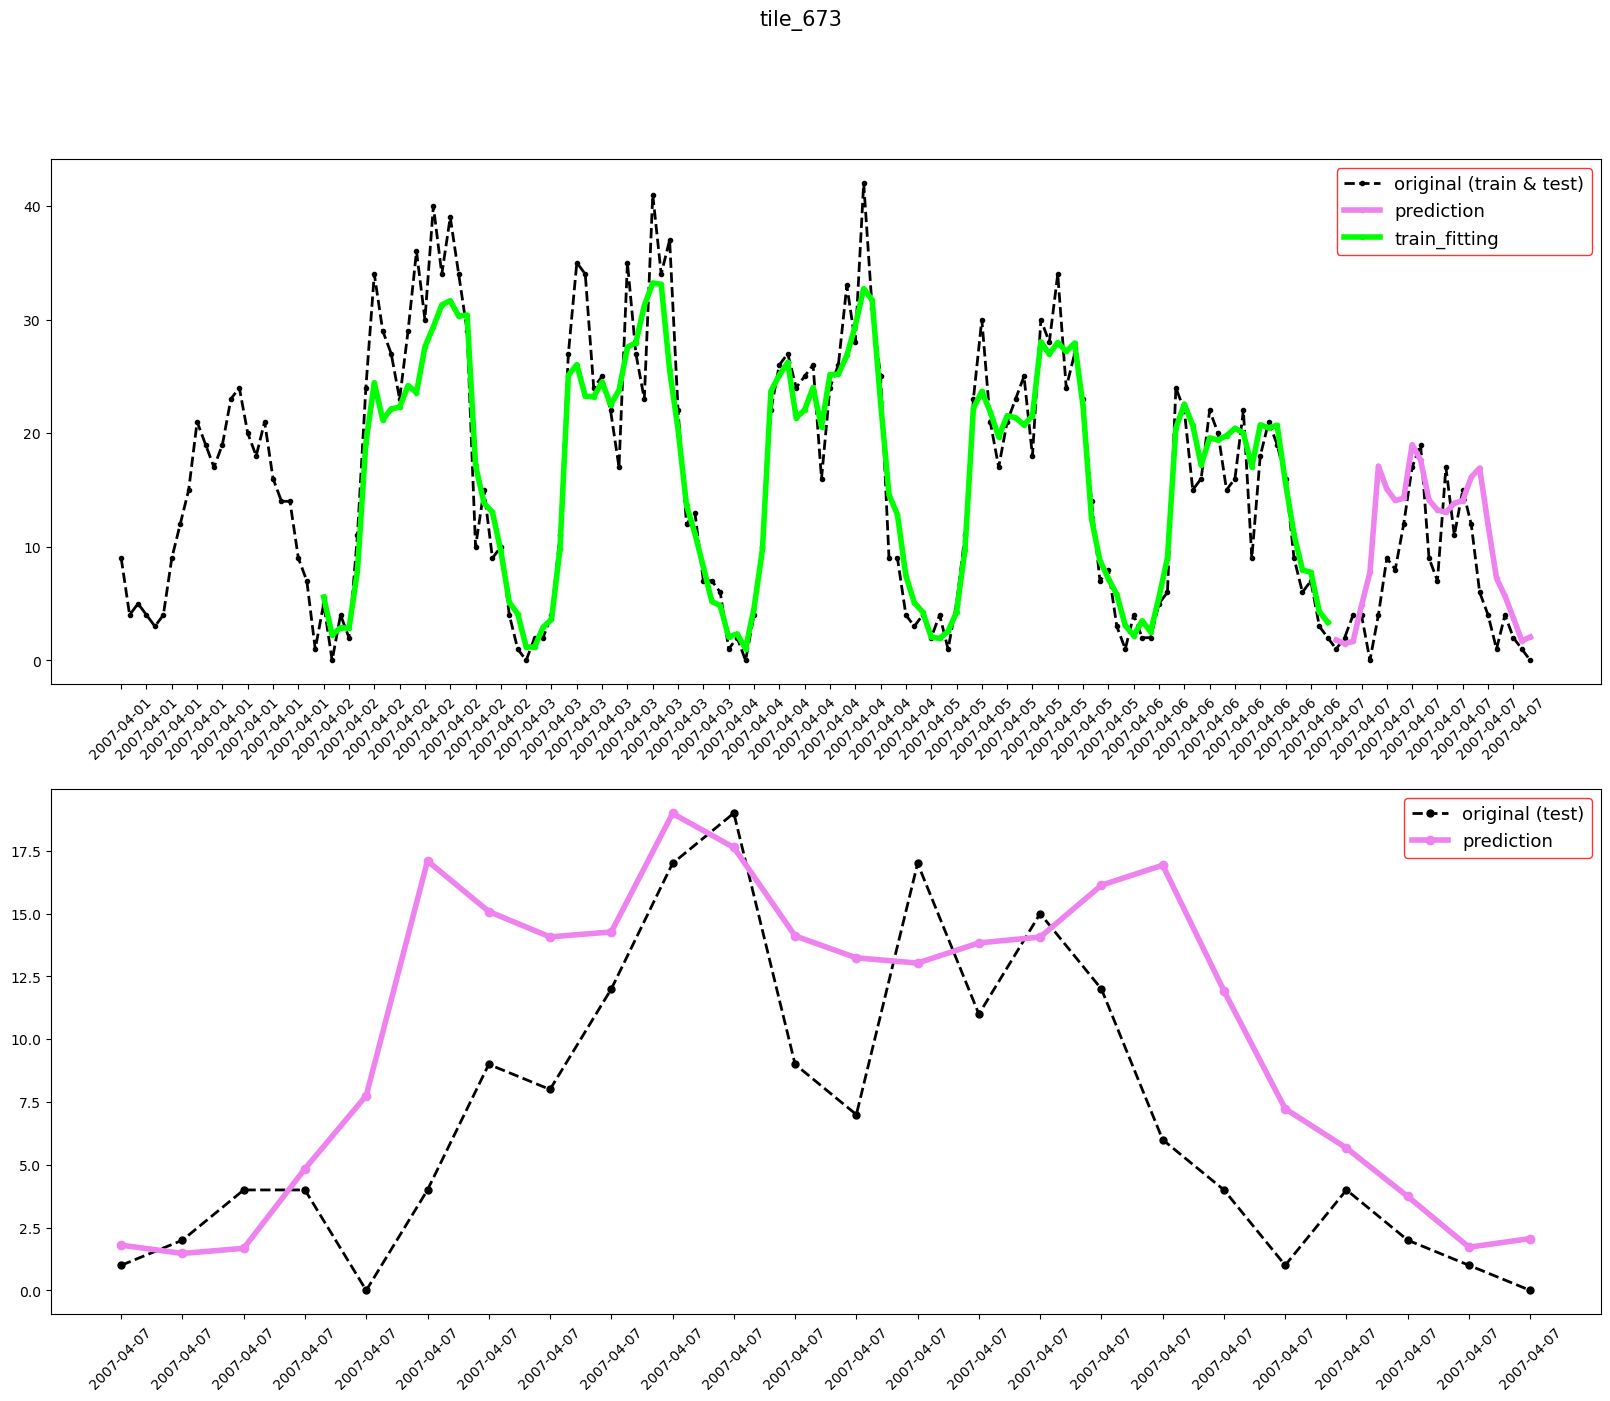

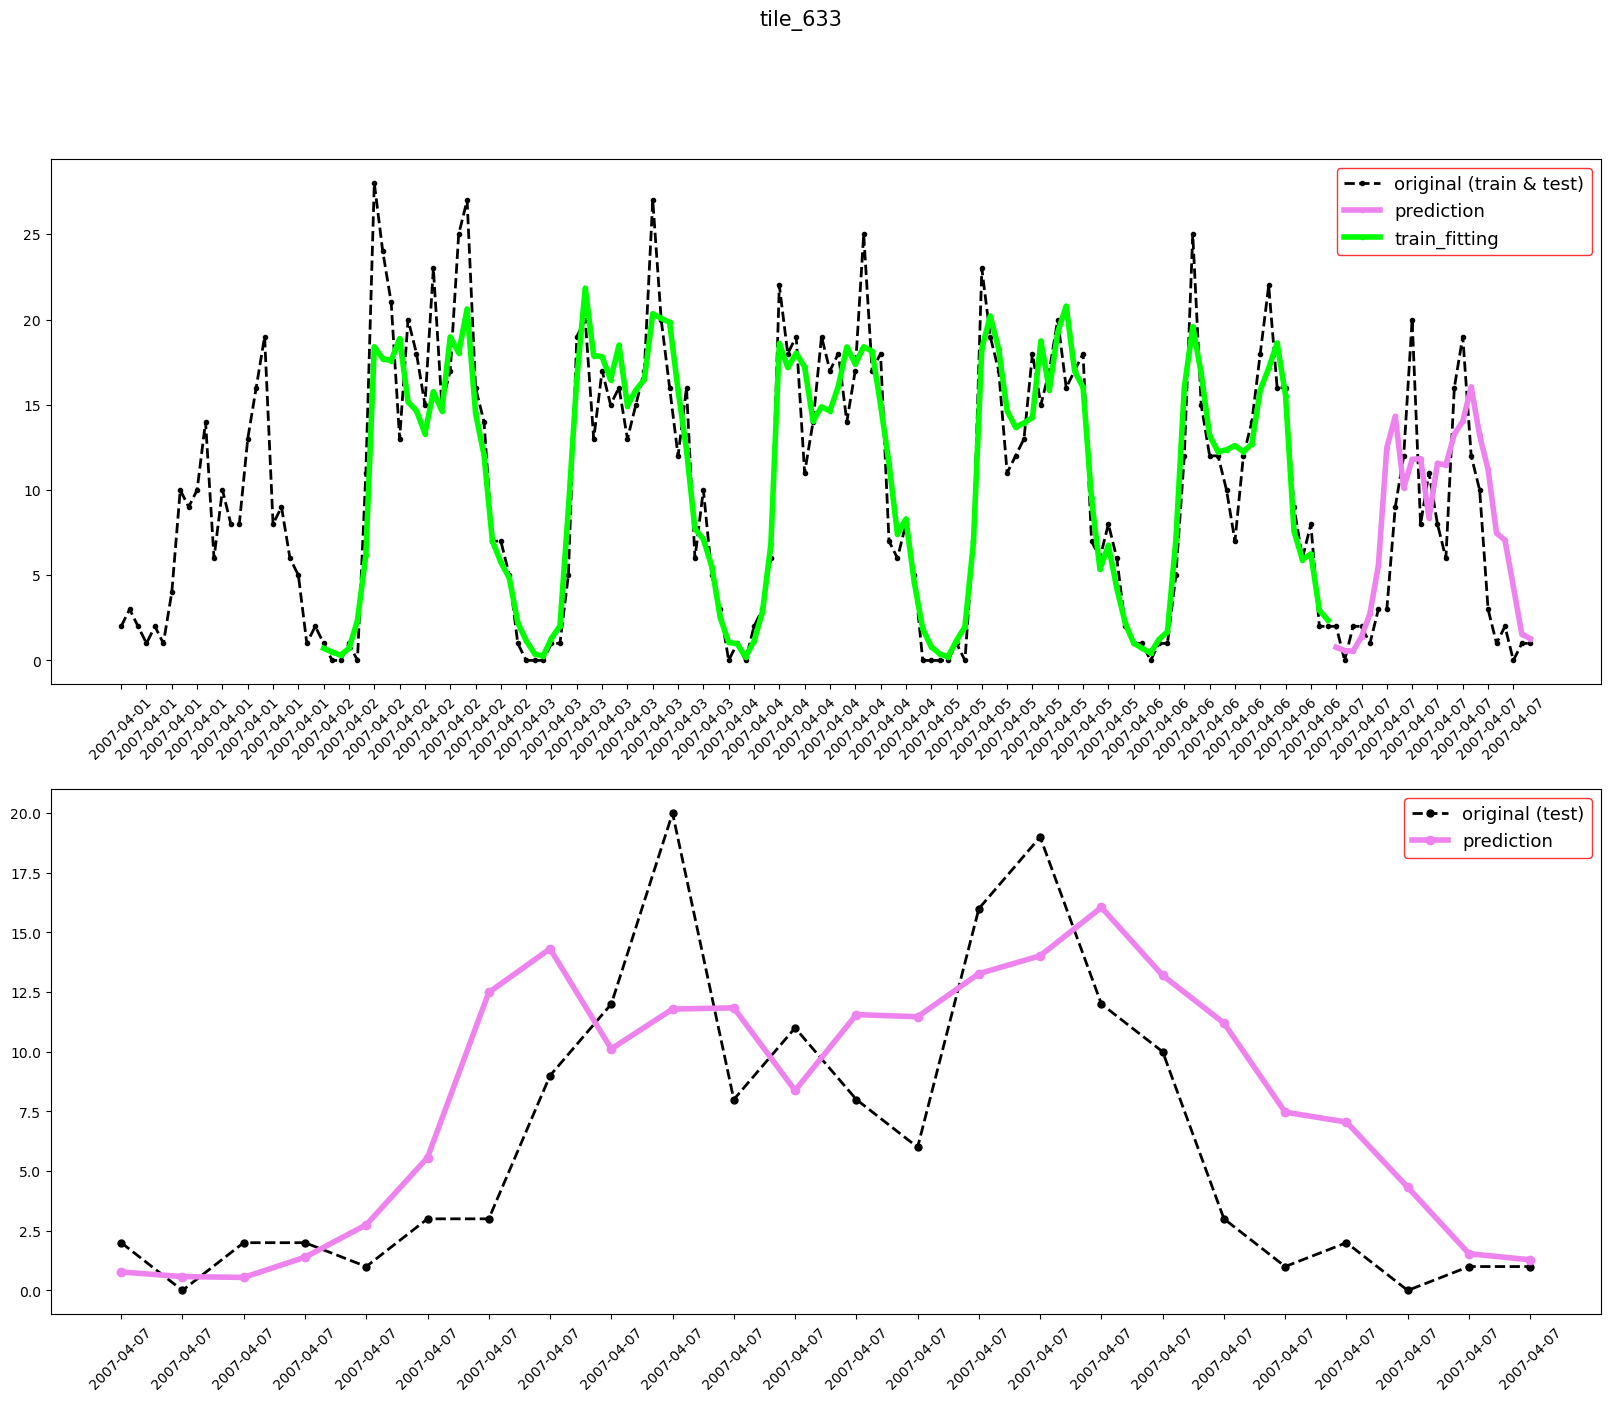

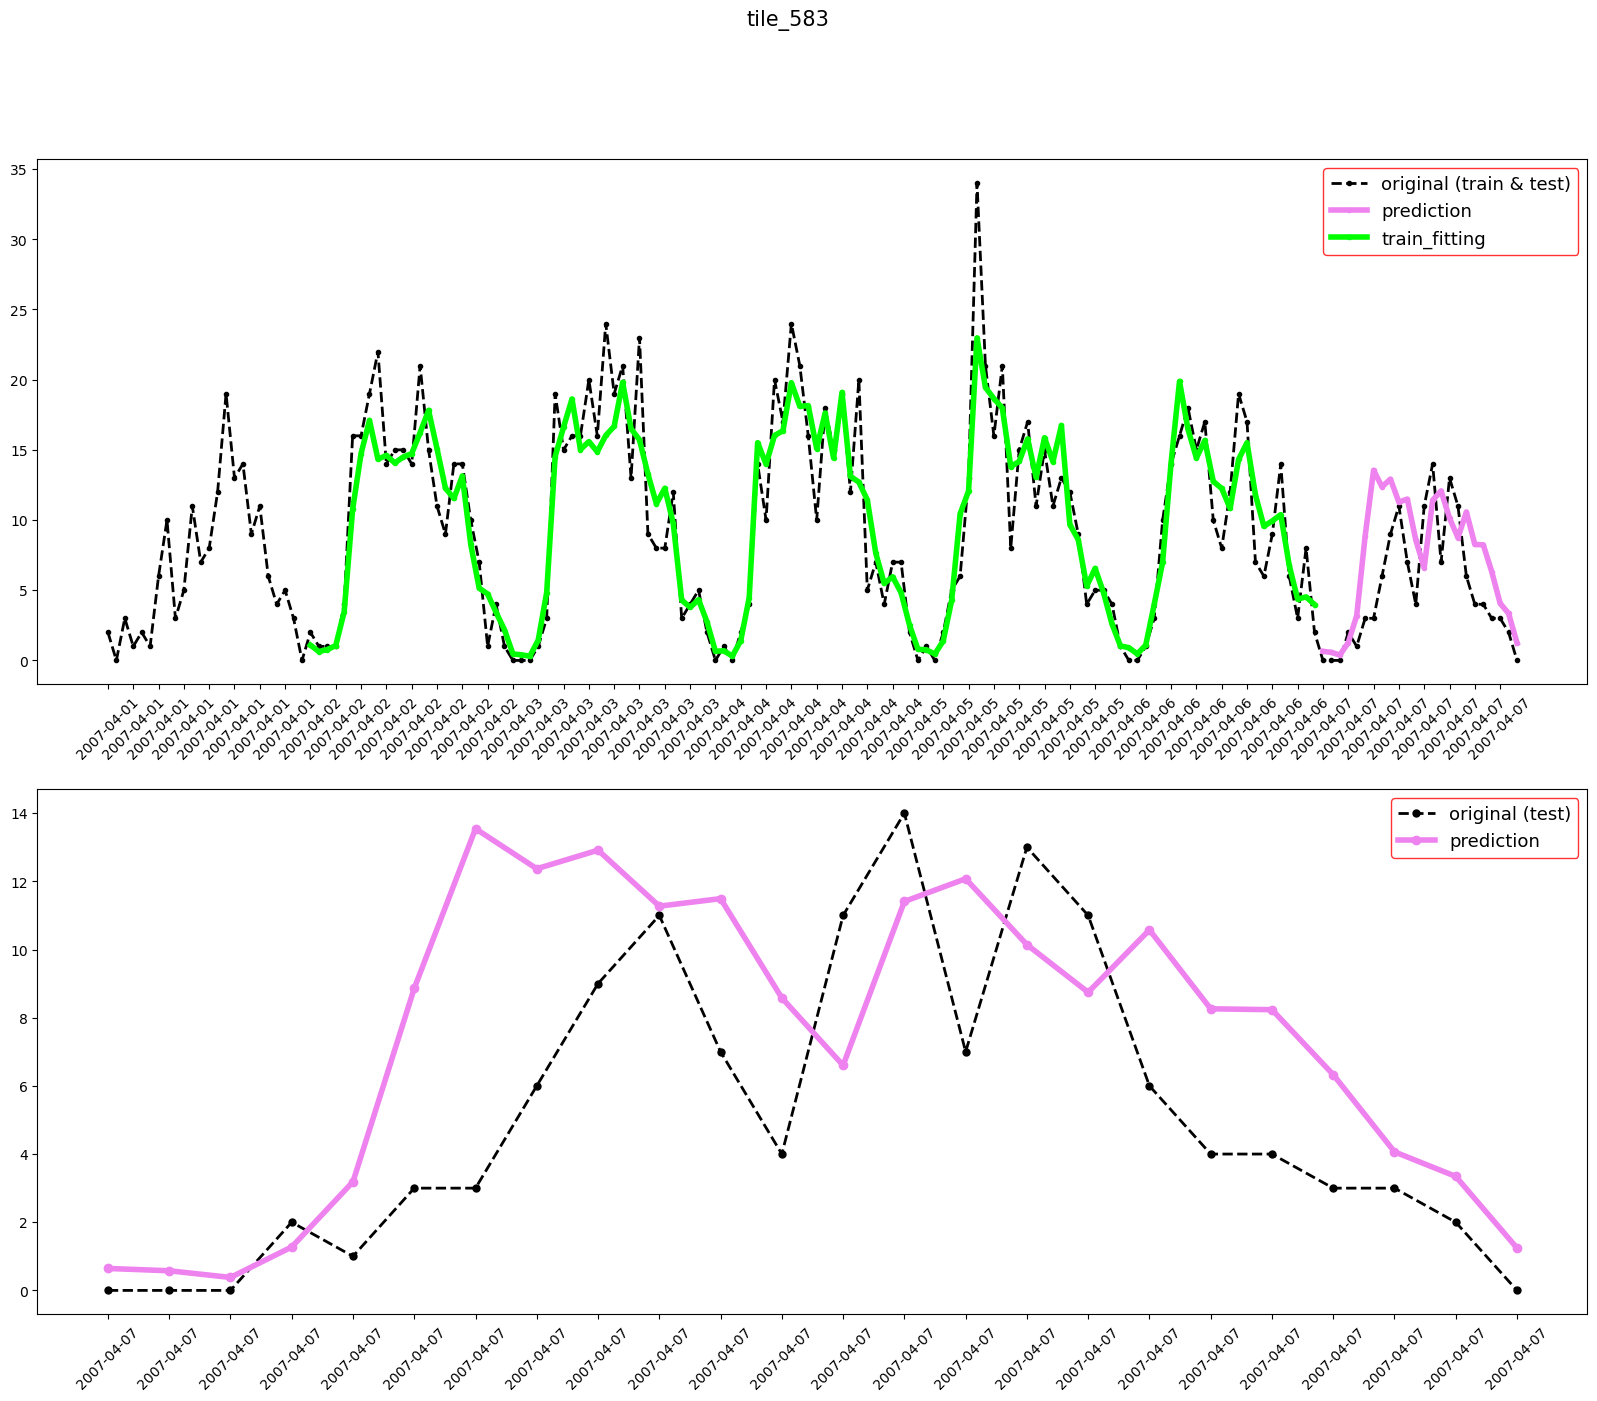

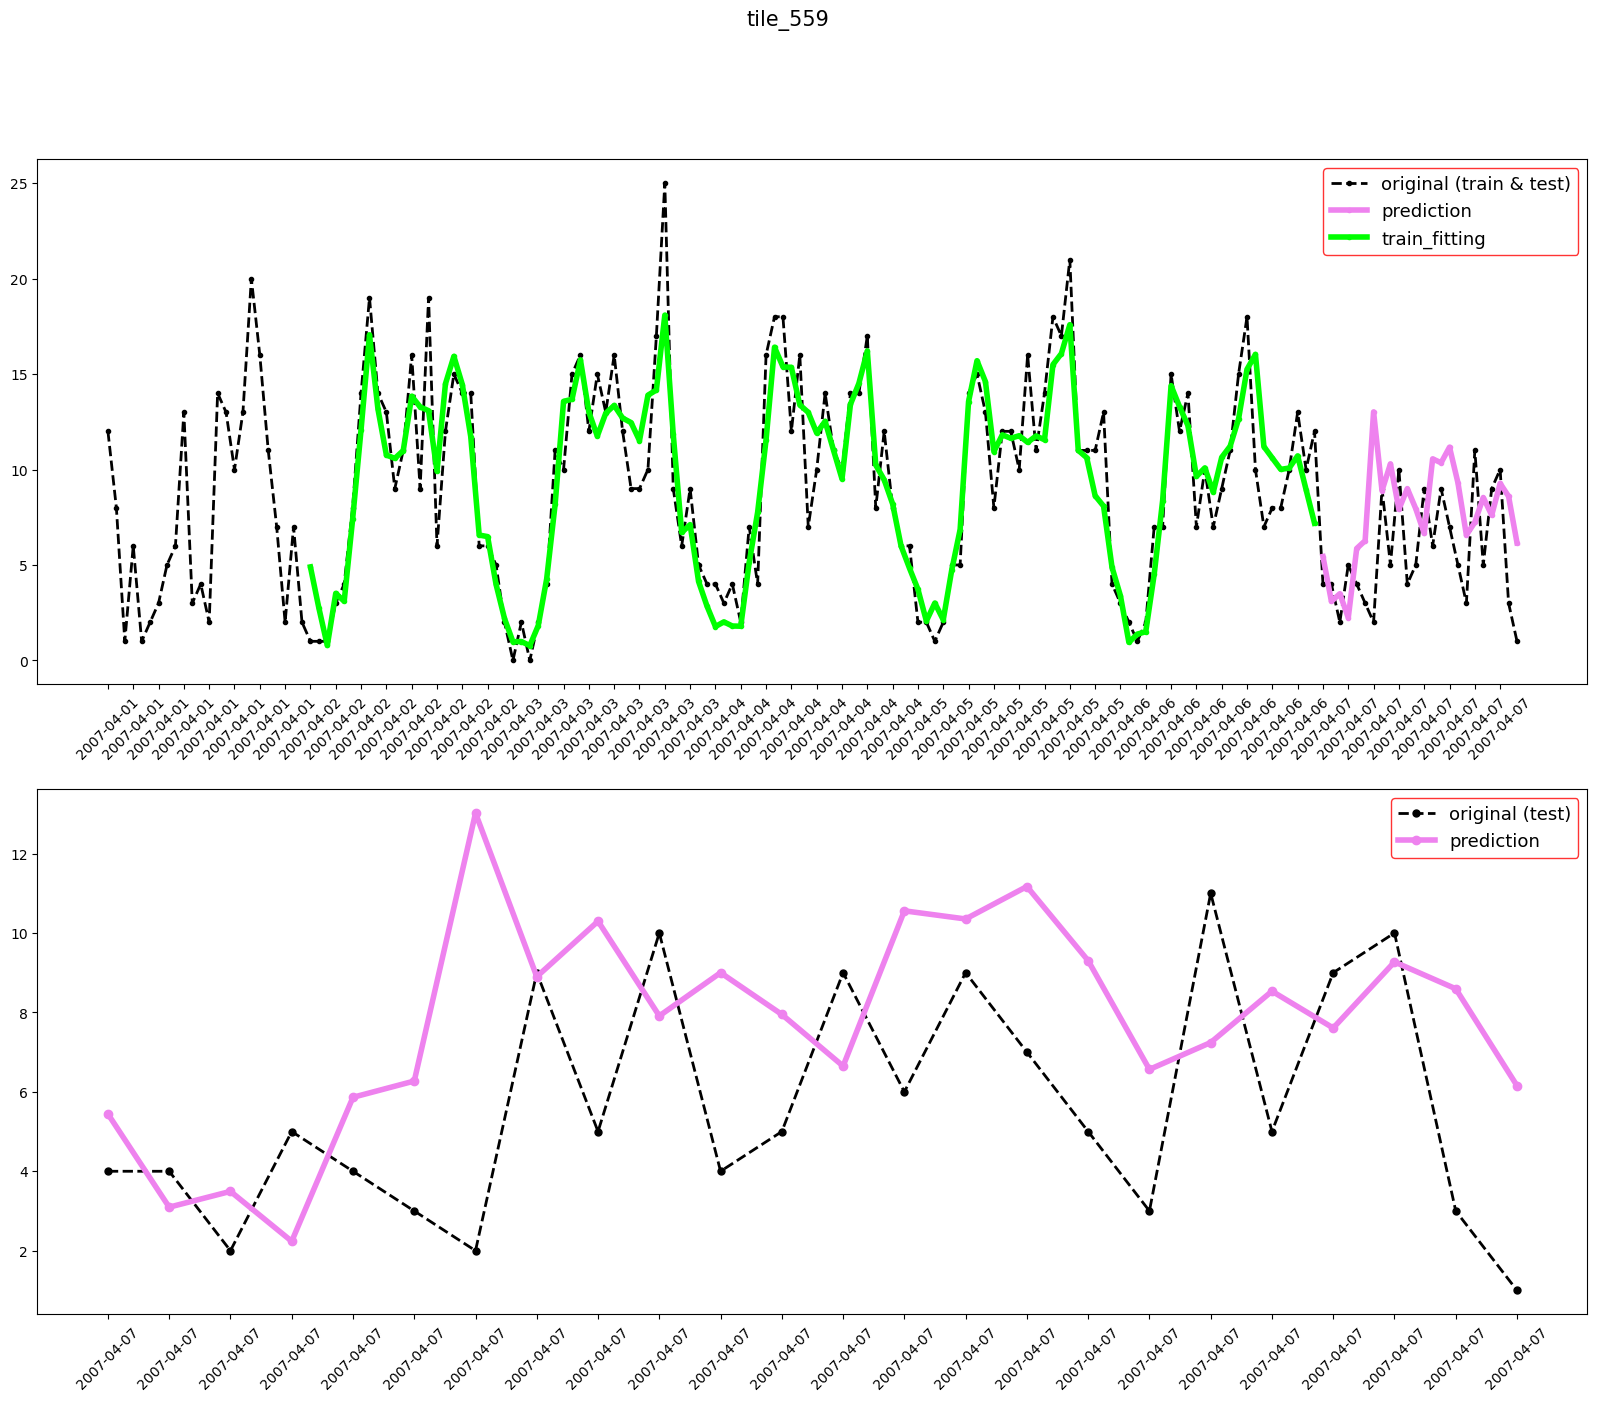

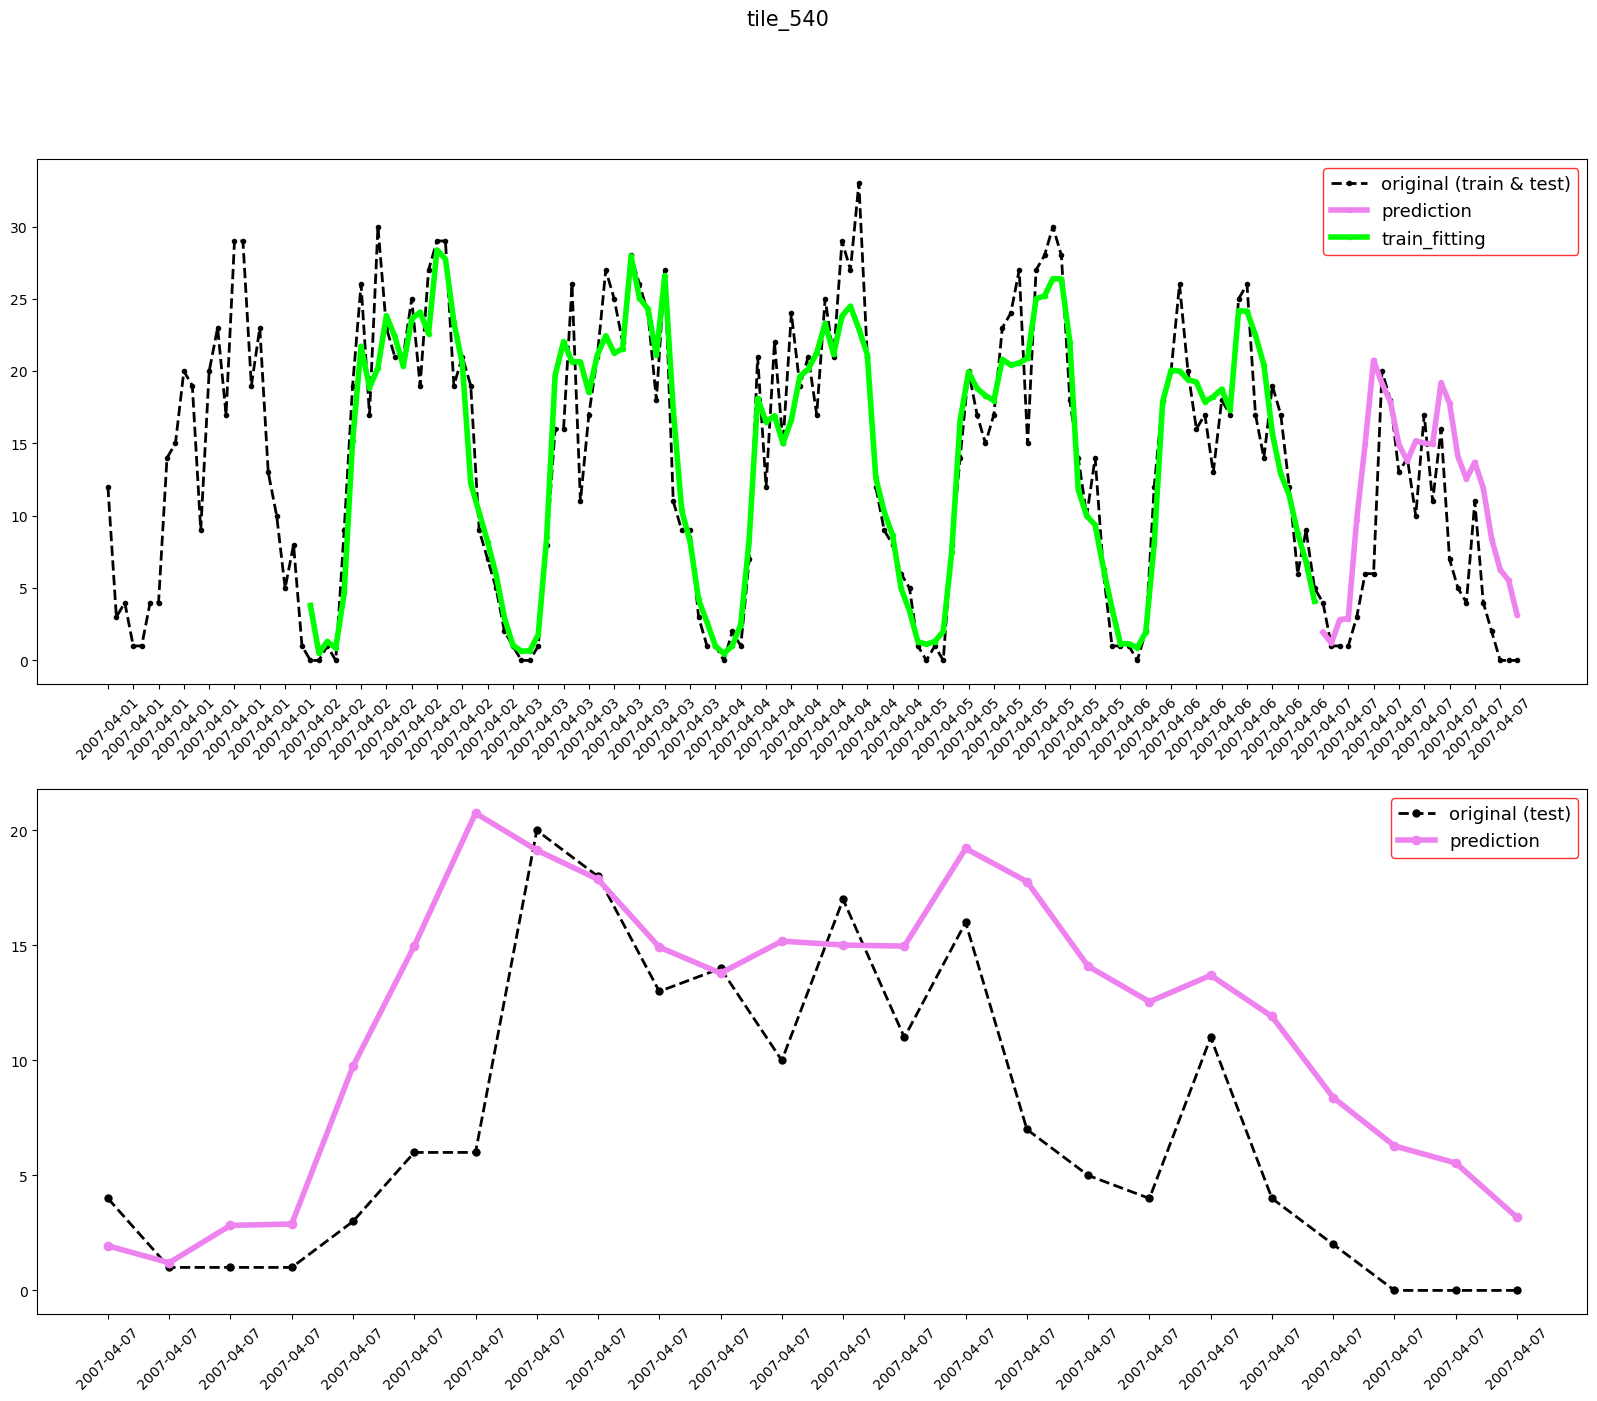

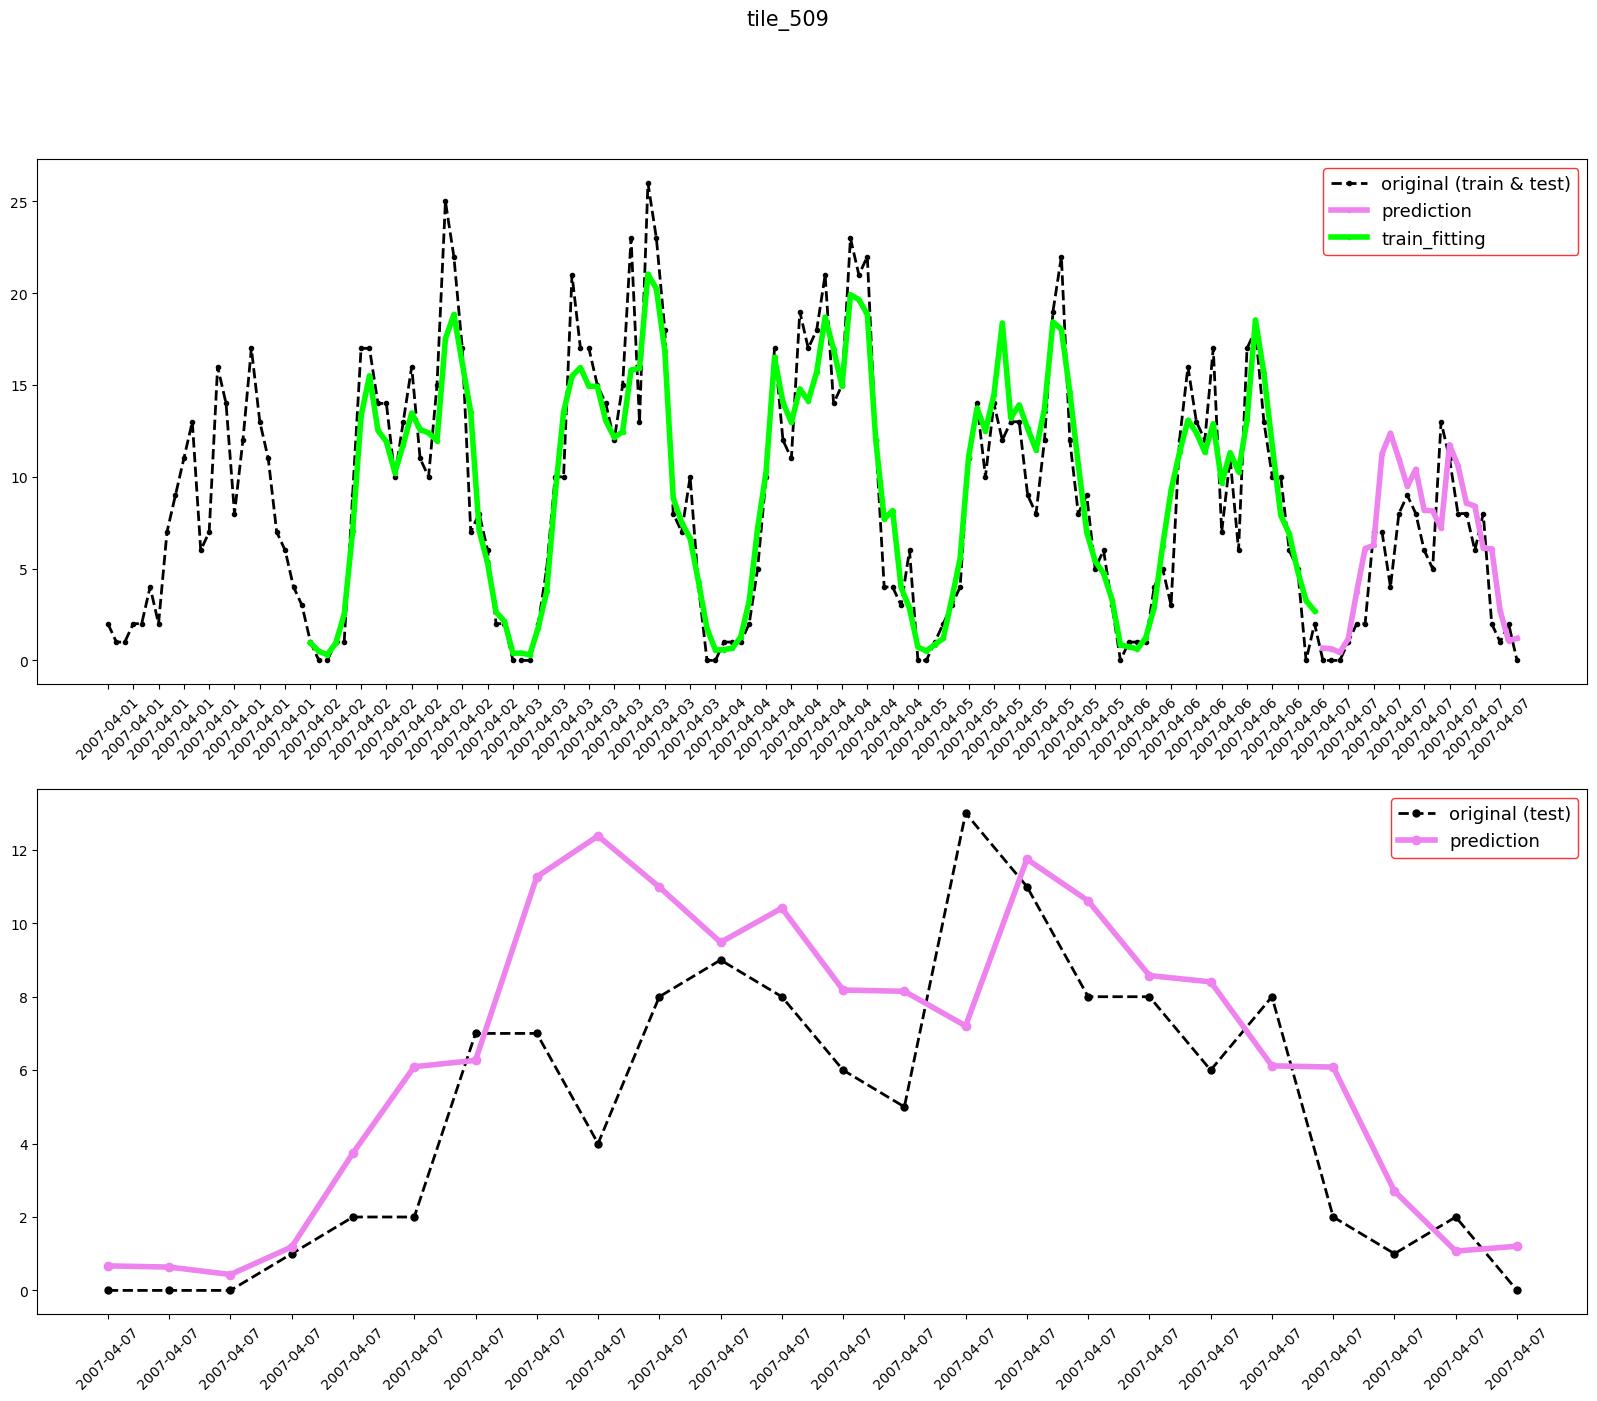

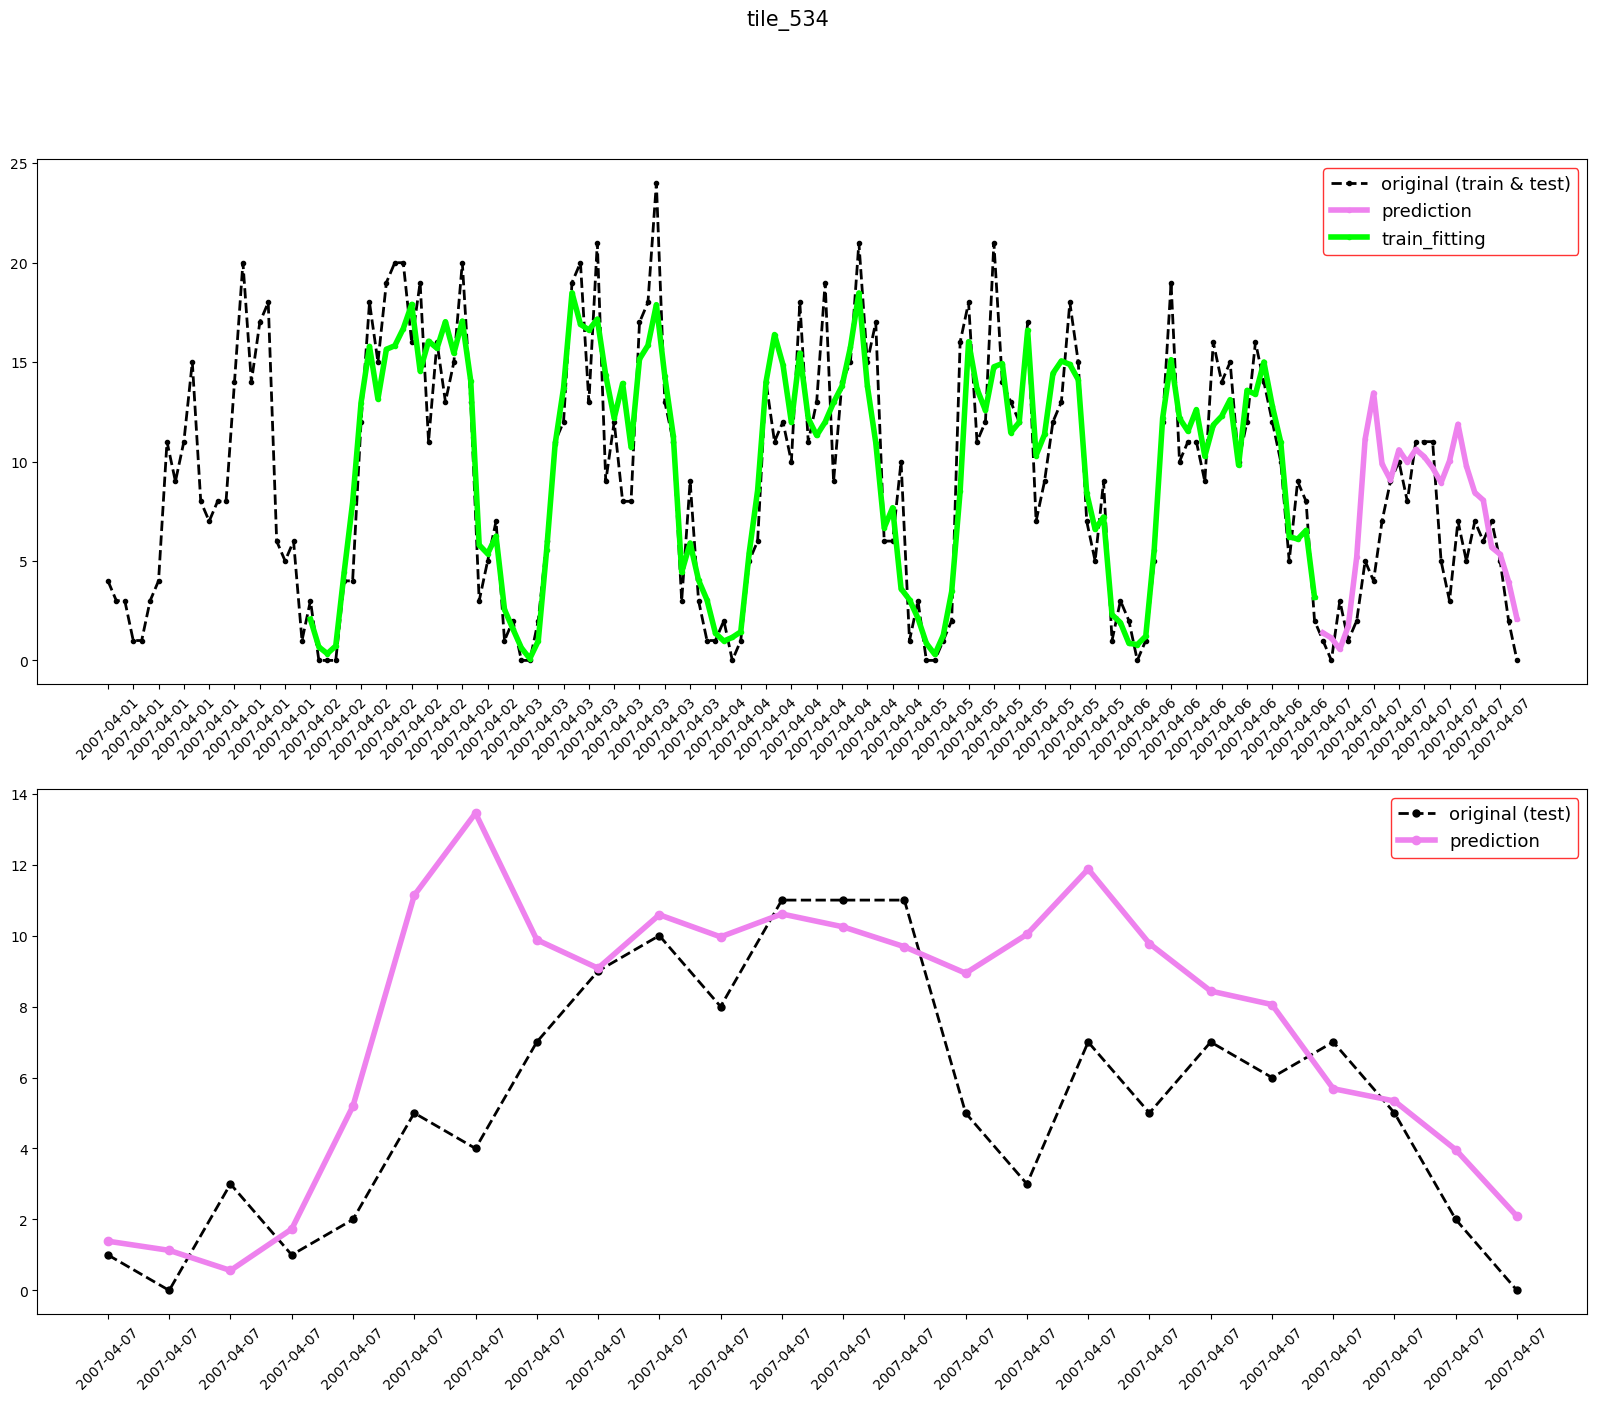

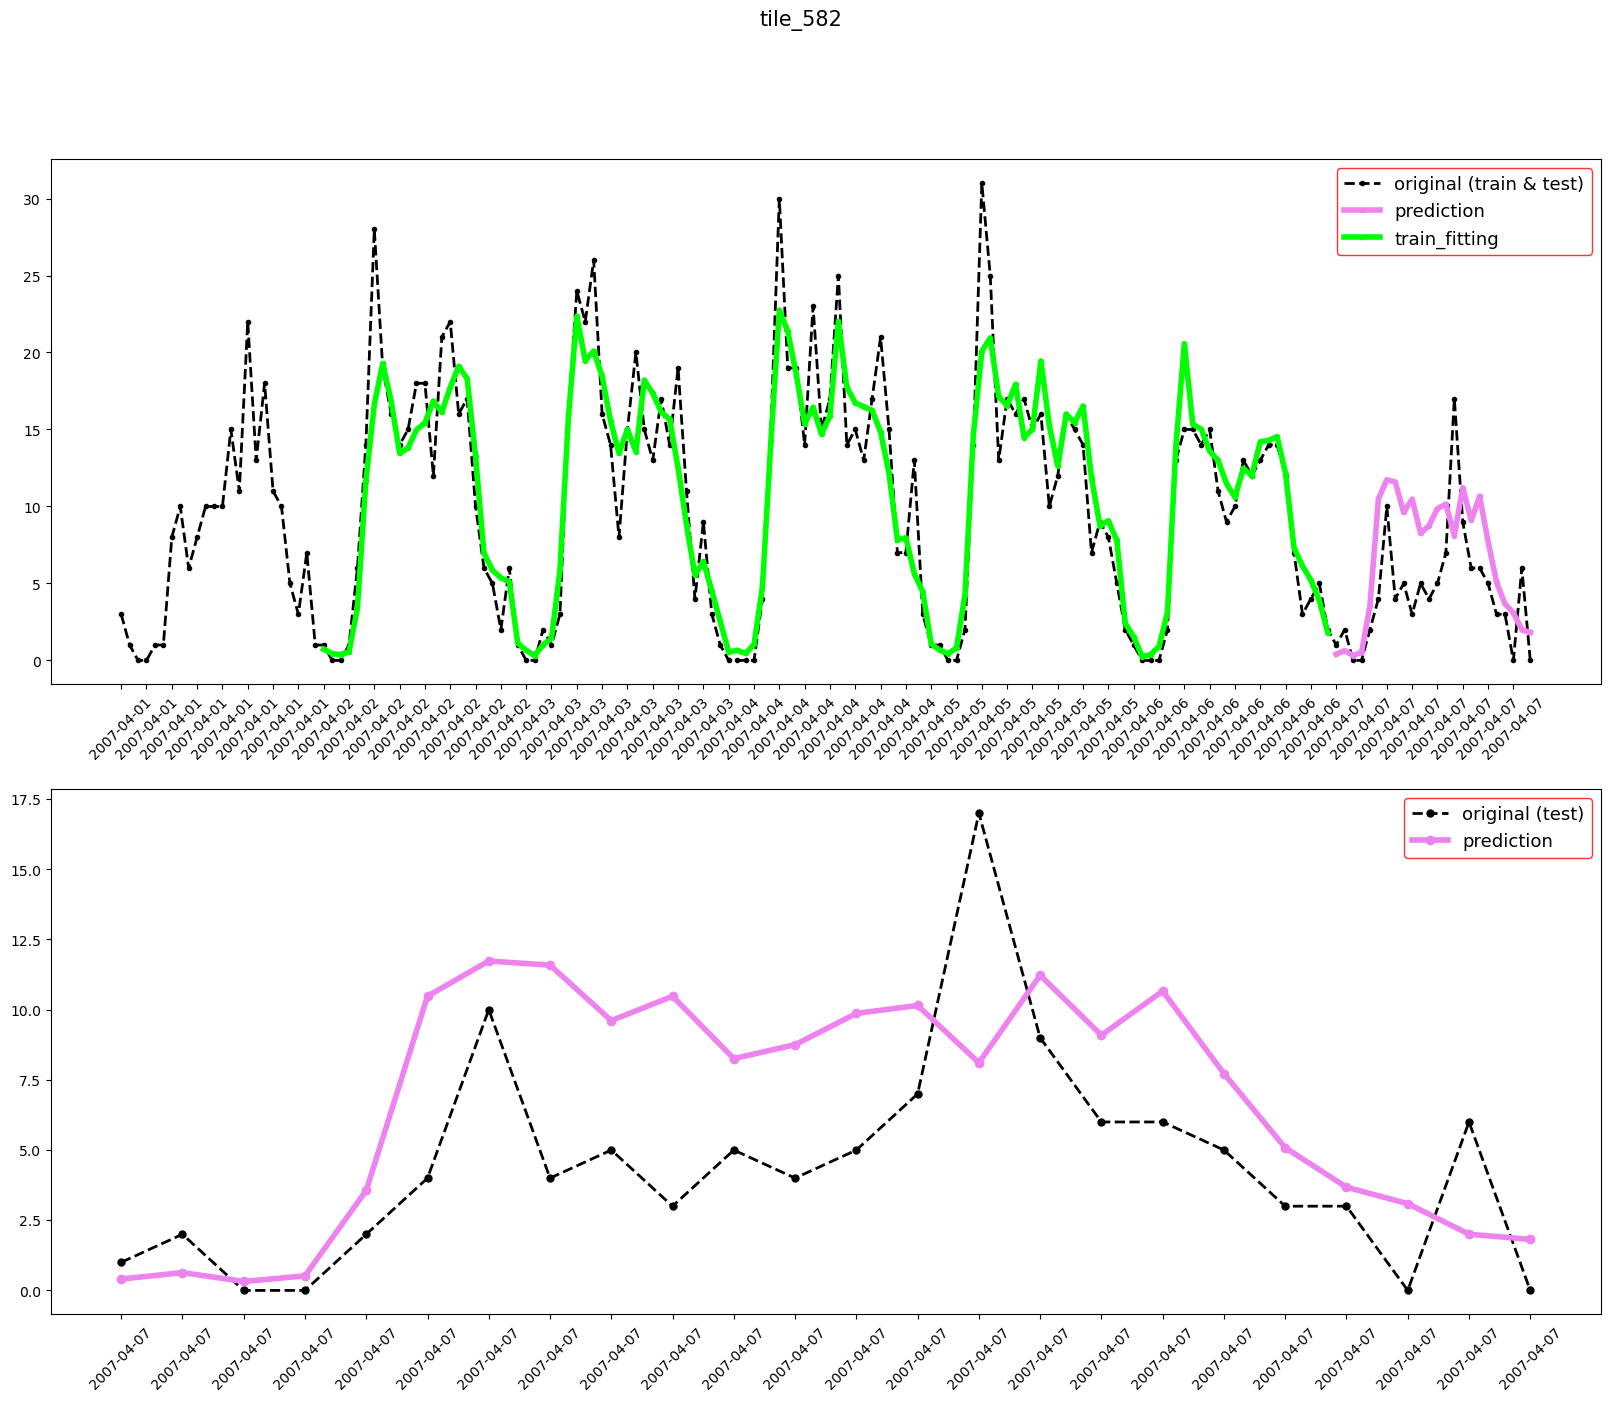

In [42]:
from ProjectWork_forecasting_functions import make_plot_leaves

N_leaf_to_plot = 10

idx_plot = df_ts[list_tiles].T.iloc[:, -12:].sum(axis = 1).sort_values(ascending = False).head(N_leaf_to_plot).index


make_plot_leaves(A = df_ts[list_tiles].T,
                 df_y_train_pred = df_y_train_pred, 
                 df_y_test = df_y_test, 
                 df_y_pred = df_y_pred, 
                 lista_leaves = list(idx_plot), 
                 test_loops = test_loops)

# Time Series Forecasting using Exponential Smoothing

In [43]:
df_ts[list_tiles]

tile_665  tile_673  tile_670  tile_634  tile_583  \
datetime                                                                
2007-04-01 00:00:00       0.0       9.0       5.0      12.0       2.0   
2007-04-01 01:00:00       1.0       4.0       1.0       9.0       0.0   
2007-04-01 02:00:00       1.0       5.0       1.0       4.0       3.0   
2007-04-01 03:00:00       1.0       4.0       2.0       2.0       1.0   
2007-04-01 04:00:00       0.0       3.0       0.0       2.0       2.0   
...                       ...       ...       ...       ...       ...   
2007-04-07 19:00:00       2.0       1.0       1.0       5.0       4.0   
2007-04-07 20:00:00       0.0       4.0       1.0       4.0       3.0   
2007-04-07 21:00:00       0.0       2.0       0.0       3.0       3.0   
2007-04-07 22:00:00       0.0       1.0       0.0       0.0       2.0   
2007-04-07 23:00:00       0.0       0.0       0.0       0.0       0.0   

                     tile_610  tile_598  tile_403  tile_628  tile_501  ...  \
datetime                                                               ...   
2007-04-01 00:00:00       4.0       1.0       3.0       3.0       0.0  ...   
2007-04-01 01:00:00       1.0       0.0       1.0       3.0       3.0  ...   
2007-04-01 02:00:00       1.0       0.0       3.0       1.0       0.0  ...   
2007-04-01 03:00:00       1.0       0.0       0.0       2.0       2.0  ...   
2007-04-01 04:00:00       3.0       0.0       1.0       1.0       1.0  ...   
...                       ...       ...       ...       ...       ...  ...   
2007-04-07 19:00:00       1.0       1.0       3.0       3.0       0.0  ...   
2007-04-07 20:00:00       0.0       0.0       1.0       5.0       0.0  ...   
2007-04-07 21:00:00       1.0       0.0       1.0       0.0       0.0  ...   
2007-04-07 22:00:00       1.0       0.0       0.0       0.0       0.0  ...   
2007-04-07 23:00:00       0.0       0.0       0.0       0.0       0.0  ...   

                     tile_439  tile_632  tile_602  tile_514  tile_430  \
datetime                                                                
2007-04-01 00:00:00       5.0       4.0       3.0       3.0       0.0   
2007-04-01 01:00:00       2.0       1.0       2.0       0.0       0.0   
2007-04-01 02:00:00       2.0       2.0       0.0       0.0       1.0   
2007-04-01 03:00:00       1.0       0.0       0.0       0.0       1.0   
2007-04-01 04:00:00       0.0       0.0       0.0       0.0       0.0   
...                       ...       ...       ...       ...       ...   
2007-04-07 19:00:00       1.0       7.0       2.0       1.0       0.0   
2007-04-07 20:00:00       1.0       1.0       2.0       3.0       0.0   
2007-04-07 21:00:00       0.0       2.0       0.0       0.0       1.0   
2007-04-07 22:00:00       0.0       0.0       1.0       0.0       0.0   
2007-04-07 23:00:00       0.0       0.0       0.0       0.0       0.0   

                     tile_653  tile_412  tile_465  tile_554  tile_490  
datetime                                                               
2007-04-01 00:00:00       2.0       2.0       2.0       1.0       2.0  
2007-04-01 01:00:00       0.0       1.0       3.0       0.0       2.0  
2007-04-01 02:00:00       2.0       0.0       1.0       0.0       3.0  
2007-04-01 03:00:00       1.0       1.0       0.0       1.0       1.0  
2007-04-01 04:00:00       0.0       0.0       0.0       0.0       1.0  
...                       ...       ...       ...       ...       ...  
2007-04-07 19:00:00       0.0       1.0       1.0       0.0       0.0  
2007-04-07 20:00:00       0.0       0.0       4.0       1.0       2.0  
2007-04-07 21:00:00       0.0       0.0       0.0       0.0       1.0  
2007-04-07 22:00:00       1.0       1.0       0.0       0.0       0.0  
2007-04-07 23:00:00       0.0       0.0       0.0       0.0       0.0  

[168 rows x 98 columns]

In [44]:
xlen, ylen, test_loops

(24, 1, 24)

In [45]:
tile = 'tile_634'
ts_train = df_ts[tile].iloc[:-test_loops]
ts_test = df_ts[tile].iloc[-test_loops:]
print(ts_train.shape)
print(ts_test.shape)

(144,)
(24,)


In [46]:
ts_train.tail()

datetime
2007-04-06 19:00:00    10.0
2007-04-06 20:00:00     5.0
2007-04-06 21:00:00    11.0
2007-04-06 22:00:00     4.0
2007-04-06 23:00:00     2.0
Freq: H, Name: tile_634, dtype: float64

In [47]:
ts_test.head()

datetime
2007-04-07 00:00:00    2.0
2007-04-07 01:00:00    4.0
2007-04-07 02:00:00    0.0
2007-04-07 03:00:00    2.0
2007-04-07 04:00:00    5.0
Freq: H, Name: tile_634, dtype: float64

Divido il dataset in train e test set per la generica serie:

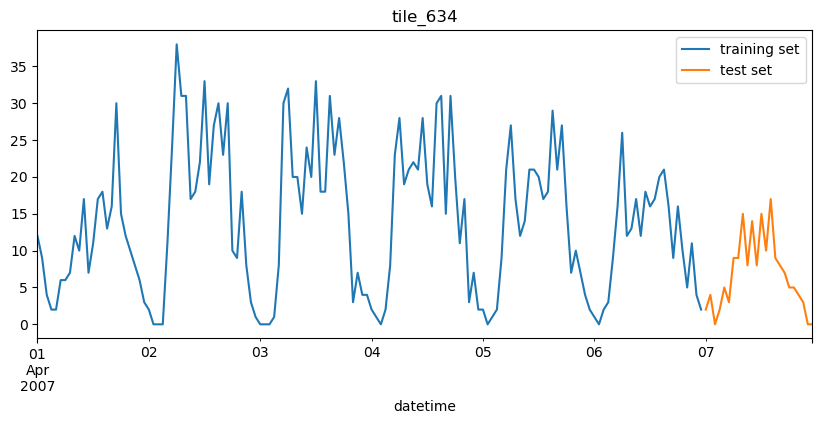

In [48]:
fig, ax = plt.subplots(figsize = (10, 4))
ts_train.plot(ax = ax, label = 'training set')
ts_test.plot(ax = ax, label = 'test set')
plt.legend()
ax.set_title(tile);

Potrei applicare direttamente lo smorzamento esponenziale come segue:

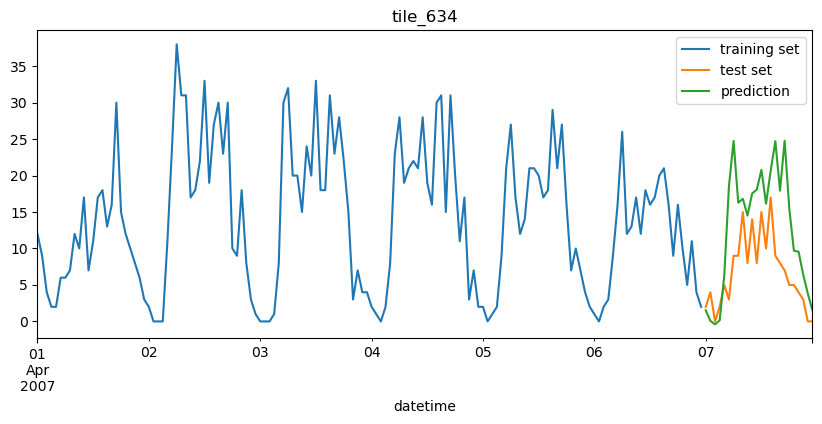

In [49]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

seasonal_periods = 24

es = ExponentialSmoothing(ts_train, seasonal_periods = seasonal_periods, trend = None, seasonal = 'add').fit()
ts_pred = es.predict(start = ts_test.index[0], end = ts_test.index[-1])

fig, ax = plt.subplots(figsize = (10, 4))
ts_train.plot(ax = ax, label = 'training set')
ts_test.plot(ax = ax, label = 'test set')
ts_pred.plot(ax = ax, label = 'prediction')
plt.legend()
ax.set_title(tile);

Tuttavia il confronto con il machine learning non sarebbe alla pari in quanto qui la predizione viene fatta direttamente 24 ore nel futuro, mentre nel caso del machine learning qui sopra, la predizione viene fatta di 1 step nel futuro con il meccanismo del lagging. Quindi devo trovare una soluzione simile anche qui:

In [50]:
def ExpSmoothRolling(x, ylen, period_to_forecast = 0):

    list_y_pred = []

    for t in range(test_loops):
        
        if -test_loops+t+ylen == 0:
            series_y_train = x.iloc[:-ylen]
            series_y_test = x.iloc[-ylen:]
            
        else:
            series_y_train = x.iloc[:-test_loops+t]
            series_y_test = x.iloc[-test_loops+t:-test_loops+t+ylen]
        
        es = ExponentialSmoothing(series_y_train, seasonal_periods = seasonal_periods, trend = None, seasonal = 'add').fit()
        # Faccio solo ylen step nel futuro come nel Machine Learning 
        series_y_pred = es.predict(start = series_y_test.index[0], end = series_y_test.index[ylen-1])
        
        # Isolo lo step nel futuro che voglio fare, ovvero la profondità temporale di forecasting
        idx = series_y_pred.index[period_to_forecast]
        val = series_y_pred.iloc[period_to_forecast]
        series_y_pred = pd.Series([val], index = [idx])
        list_y_pred.append(series_y_pred)

    # Mi creo la serie delle predizioni
    series_y_pred = list_y_pred[0]
    for elem in list_y_pred[1:]:
        series_y_pred = pd.concat([series_y_pred, elem], axis = 0)
        
    return series_y_pred

period_to_forecast = 0
series_y_pred = ExpSmoothRolling(df_ts[tile], ylen, period_to_forecast )
series_y_pred

2007-04-07 00:00:00     1.531740
2007-04-07 01:00:00     0.234081
2007-04-07 02:00:00     1.100902
2007-04-07 03:00:00     1.234219
2007-04-07 04:00:00     7.696996
2007-04-07 05:00:00    18.948958
2007-04-07 06:00:00    19.513889
2007-04-07 07:00:00     6.144800
2007-04-07 08:00:00     8.086203
2007-04-07 09:00:00     8.566882
2007-04-07 10:00:00    11.430571
2007-04-07 11:00:00    12.968842
2007-04-07 12:00:00    13.861944
2007-04-07 13:00:00     9.698986
2007-04-07 14:00:00    14.389078
2007-04-07 15:00:00    19.429329
2007-04-07 16:00:00     8.906731
2007-04-07 17:00:00    15.495268
2007-04-07 18:00:00     2.999434
2007-04-07 19:00:00    -1.919286
2007-04-07 20:00:00     0.549922
2007-04-07 21:00:00    -1.264251
2007-04-07 22:00:00    -2.233722
2007-04-07 23:00:00    -3.619480
dtype: float64

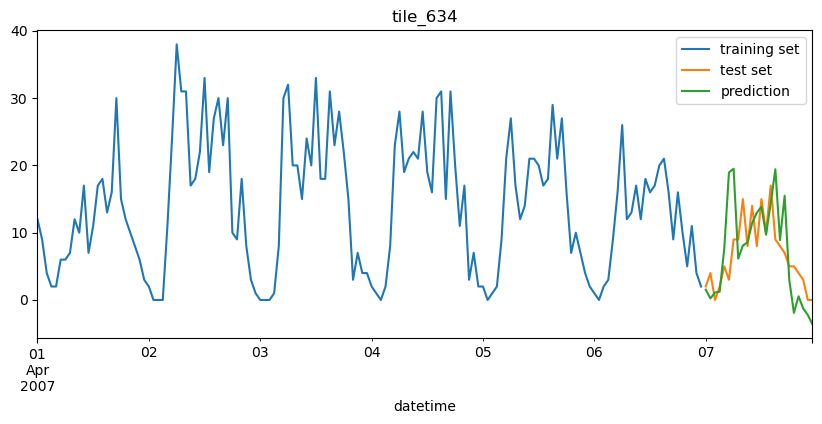

In [51]:
fig, ax = plt.subplots(figsize = (10, 4))
ts_train.plot(ax = ax, label = 'training set')
ts_test.plot(ax = ax, label = 'test set')
series_y_pred.plot(ax = ax, label = 'prediction')
plt.legend()
ax.set_title(tile);

In [52]:
list_y_pred_ExpSmooth = []

for col in list_tiles:
    series_y_pred = ExpSmoothRolling(df_ts[col], ylen)
    series_y_pred.name = col
    list_y_pred_ExpSmooth.append(series_y_pred.to_frame().T)
    

df_y_pred_ExpSmooth = pd.concat(list_y_pred_ExpSmooth, axis = 0)
print(df_y_pred_ExpSmooth.shape)
df_y_pred_ExpSmooth.head()

(98, 24)


2007-04-07 00:00:00  2007-04-07 01:00:00  2007-04-07 02:00:00  \
tile_665            -1.216654             0.060727            -0.946078   
tile_673             1.580120             0.153707             1.109040   
tile_670             1.181758             1.058950             0.423166   
tile_634             1.531740             0.234081             1.100902   
tile_583             1.279023             0.699675             0.731139   

          2007-04-07 03:00:00  2007-04-07 04:00:00  2007-04-07 05:00:00  \
tile_665             0.004556             0.670483             2.421304   
tile_673             4.250772             8.811841            16.487743   
tile_670             1.816943             1.270689             4.960326   
tile_634             1.234219             7.696996            18.948958   
tile_583             1.260589             3.531536            10.605958   

          2007-04-07 06:00:00  2007-04-07 07:00:00  2007-04-07 08:00:00  \
tile_665             5.659323             3.986014             2.237011   
tile_673            15.087022             8.512748             5.827793   
tile_670             7.848417             5.941130             4.208384   
tile_634            19.513889             6.144800             8.086203   
tile_583            10.627229            15.271571             8.715224   

          2007-04-07 09:00:00  ...  2007-04-07 14:00:00  2007-04-07 15:00:00  \
tile_665             1.878427  ...             3.354302             3.982359   
tile_673            11.737461  ...            13.272854            16.940942   
tile_670             4.028938  ...             4.169132             5.307348   
tile_634             8.566882  ...            14.389078            19.429329   
tile_583             8.369946  ...            10.328519            10.397470   

          2007-04-07 16:00:00  2007-04-07 17:00:00  2007-04-07 18:00:00  \
tile_665             5.080417             3.788300             0.105016   
tile_673            14.797706            11.837680            -0.048949   
tile_670             2.522165             2.898945             0.757299   
tile_634             8.906731            15.495268             2.999434   
tile_583             5.162290             8.219047             5.735327   

          2007-04-07 19:00:00  2007-04-07 20:00:00  2007-04-07 21:00:00  \
tile_665            -0.367210            -2.114317            -2.116024   
tile_673            -4.089977            -3.589039            -1.216995   
tile_670            -1.968214            -1.820345            -1.954822   
tile_634            -1.919286             0.549922            -1.264251   
tile_583             5.101164            -0.180084             0.224095   

          2007-04-07 22:00:00  2007-04-07 23:00:00  
tile_665            -2.305660            -2.145496  
tile_673            -2.188767            -2.190346  
tile_670            -2.261255            -0.886959  
tile_634            -2.233722            -3.619480  
tile_583             2.195200            -1.346031  

[5 rows x 24 columns]

In [53]:
print(df_y_pred.shape)
df_y_pred

(98, 24)


datetime  2007-04-07 00:00:00  2007-04-07 01:00:00  2007-04-07 02:00:00  \
tile_665             0.237625             0.497984             0.789138   
tile_673             1.801892             1.472452             1.676461   
tile_670             0.308394             0.908303             0.254068   
tile_634             1.271415             0.836072             4.074445   
tile_583             0.644511             0.576412             0.380919   
...                       ...                  ...                  ...   
tile_653             0.952515             0.543830             0.238645   
tile_412             0.331548             0.359461             0.282251   
tile_465             0.805740             0.421785             0.642628   
tile_554             0.467531             0.713590             0.367275   
tile_490             1.090766             0.327620             0.043333   

datetime  2007-04-07 03:00:00  2007-04-07 04:00:00  2007-04-07 05:00:00  \
tile_665             1.008013             1.743872             3.884676   
tile_673             4.844476             7.757290            17.099358   
tile_670             0.981190             1.853534             4.415139   
tile_634             2.710120             6.956091            12.874089   
tile_583             1.274391             3.186884             8.860851   
...                       ...                  ...                  ...   
tile_653             1.260904             2.359458             5.105382   
tile_412             0.398175             1.641659             3.371322   
tile_465             1.837611             2.881333             6.021577   
tile_554             0.887499             1.508930             2.304424   
tile_490             1.403185             2.803917             4.062324   

datetime  2007-04-07 06:00:00  2007-04-07 07:00:00  2007-04-07 08:00:00  \
tile_665             3.536788             2.629661             2.959428   
tile_673            15.083838            14.073877            14.270307   
tile_670             5.824002             6.829189             4.624373   
tile_634            13.648634            11.582940            11.014190   
tile_583            13.543786            12.369249            12.913904   
...                       ...                  ...                  ...   
tile_653             4.088970             4.788754             5.008977   
tile_412             4.490046             3.269787             3.415838   
tile_465            11.443151             7.559951             9.893749   
tile_554             3.059540             4.414259             2.327144   
tile_490             5.530422             5.016394             5.972618   

datetime  2007-04-07 09:00:00  ...  2007-04-07 14:00:00  2007-04-07 15:00:00  \
tile_665             3.054437  ...             3.767830             2.992604   
tile_673            18.988360  ...            13.834278            14.066762   
tile_670             4.836833  ...             4.314137             4.569238   
tile_634            13.797089  ...            14.317718            16.188142   
tile_583            11.271571  ...            12.075449            10.142452   
...                       ...  ...                  ...                  ...   
tile_653             5.897827  ...             7.505966             8.212396   
tile_412             5.343914  ...             3.802309             3.662693   
tile_465             6.016219  ...            11.740266            10.854318   
tile_554             2.722650  ...             3.563215             4.288540   
tile_490             5.791215  ...             7.152914             5.906517   

datetime  2007-04-07 16:00:00  2007-04-07 17:00:00  2007-04-07 18:00:00  \
tile_665             2.157353             2.543718             1.846108   
tile_673            16.131427            16.928005            11.927198   
tile_670             3.947494             4.666518             2.638668   
tile_634            11.456214       

Per riusare le metriche di errore di cui sopra, è necessario riportare questo dataframe di predizioni usando l'`Exponential Smoothing` in un formato array in modo da darlo in pasto alla funzione `ML_forecast_KPI` che è stata usata anche sopra.

Il modo per passare dal formato dataframe al formato array è il seguente:
- Traspongo il dataframe di cui sopra
- Faccio un reshaping

In [54]:
# Riprova che con il dataset creato sopra nella pare del ML, questa operazione torna
(df_y_pred.T.values.reshape(-1, 1) == y_pred).all()

True

In [55]:
y_pred_ExpSmooth = df_y_pred_ExpSmooth.T.values.reshape(-1, 1)
y_pred_ExpSmooth[0:10]

array([[-1.21665414],
       [ 1.58011982],
       [ 1.18175802],
       [ 1.53174028],
       [ 1.27902278],
       [-0.11350441],
       [ 0.68696968],
       [ 1.65975036],
       [ 0.17134054],
       [ 0.33334225]])

# Confronto Exp Smoothing e ML

Come vedremo in seguito il ML sembra essere più accurato:

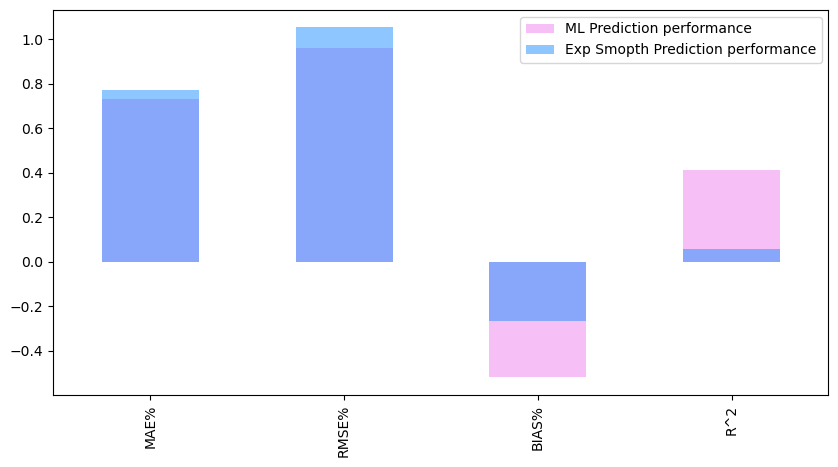

In [56]:
test_metrics_ML = ML_forecast_KPI(y_train[:, 0], y_train_pred[:, 0], y_test[:, 0], y_pred[:, 0]).loc['Test']
test_metrics_ExpSmooth = ML_forecast_KPI(y_train[:, 0], y_train_pred[:, 0], y_test[:, 0], y_pred_ExpSmooth[:, 0]).loc['Test']

fig, ax = plt.subplots(figsize = (10, 5))

test_metrics_ML.plot(kind = 'bar', ax = ax, color = 'violet', alpha = 0.5, label = 'ML Prediction performance')
test_metrics_ExpSmooth.plot(kind = 'bar', ax = ax, color = 'dodgerblue', alpha = 0.5, label = 'Exp Smopth Prediction performance')
plt.legend()
plt.show()

# Data Viz per confronto Exp Smoothing e ML

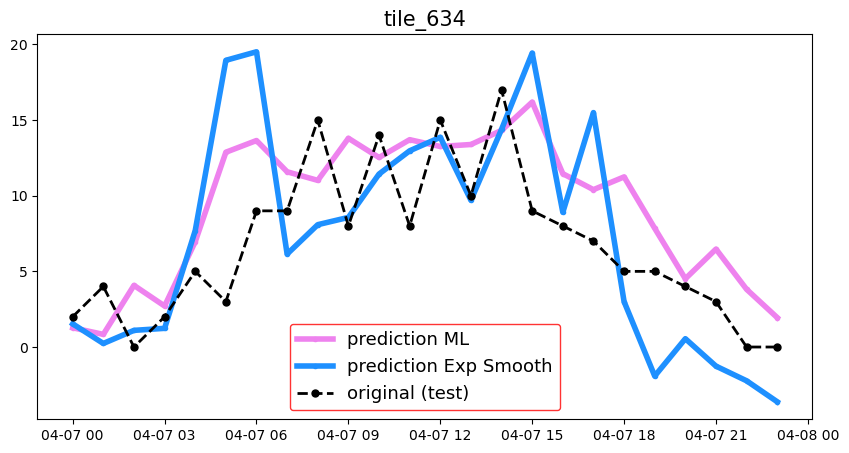

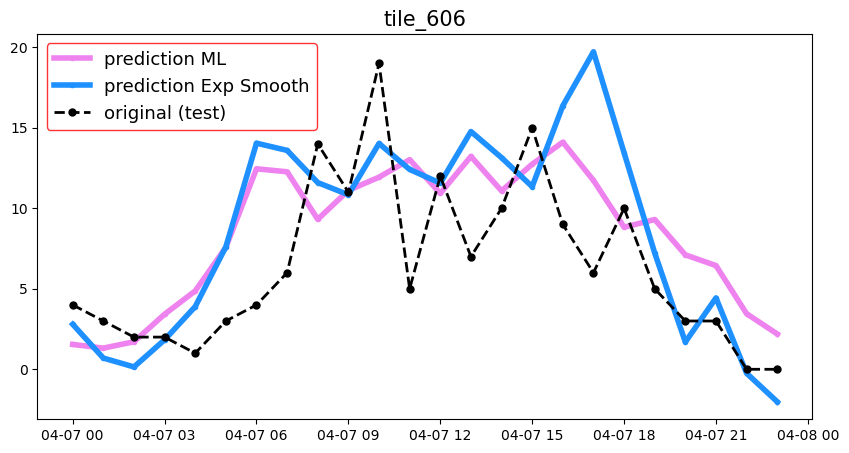

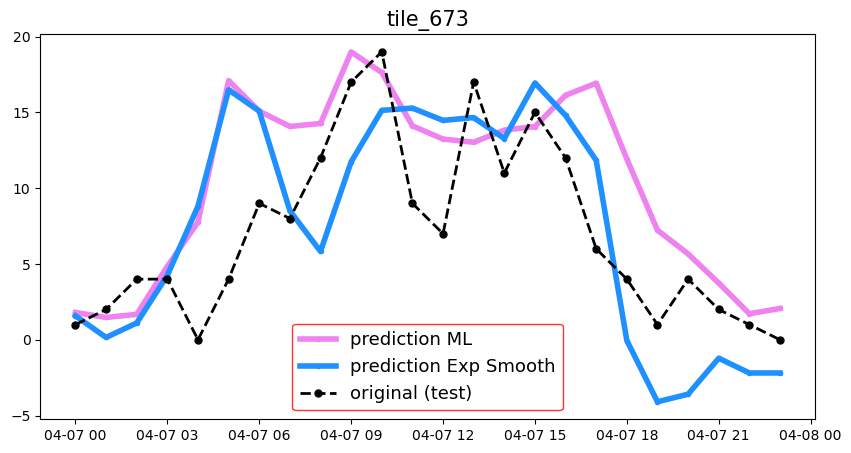

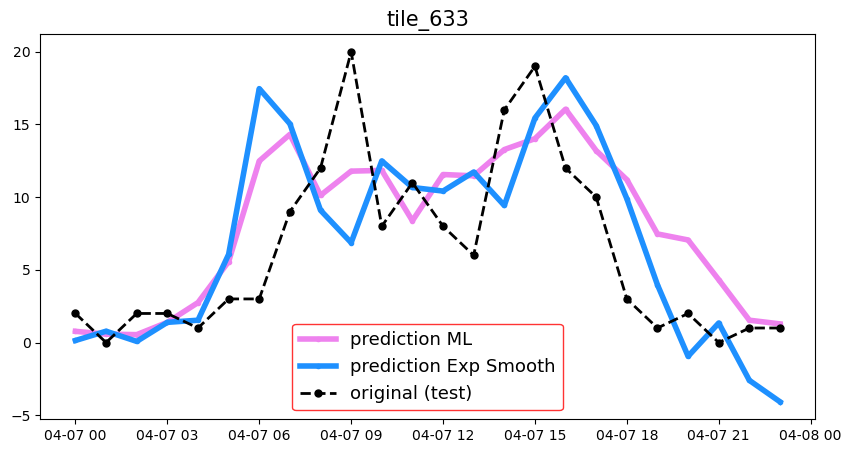

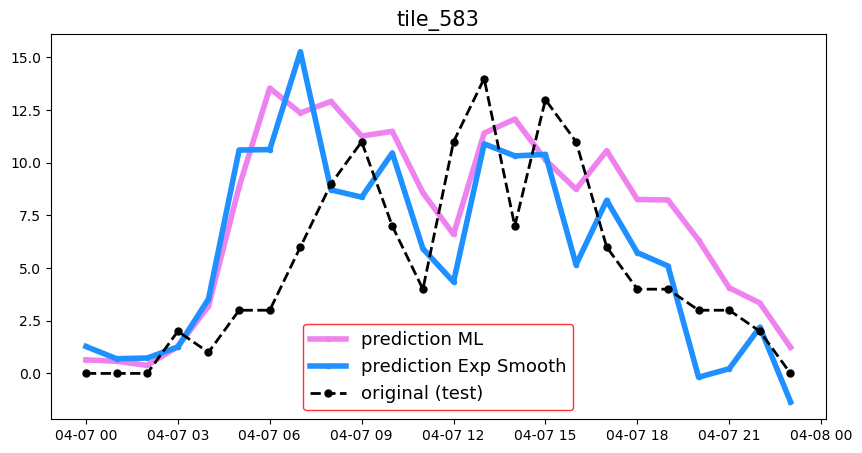

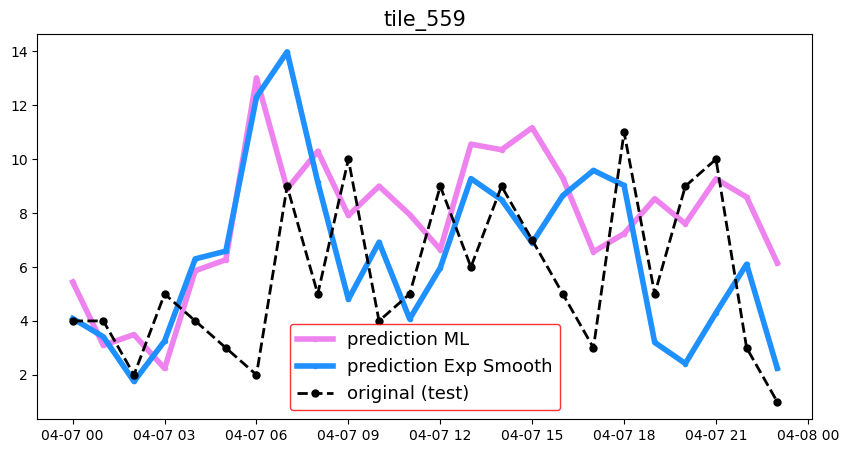

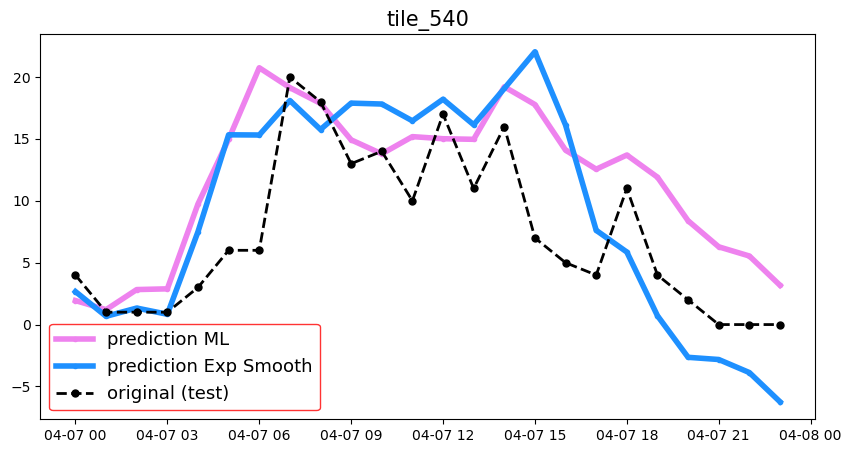

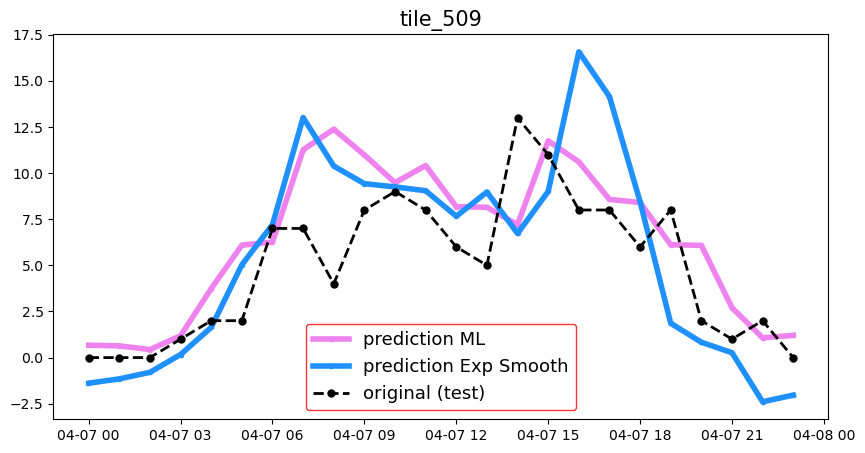

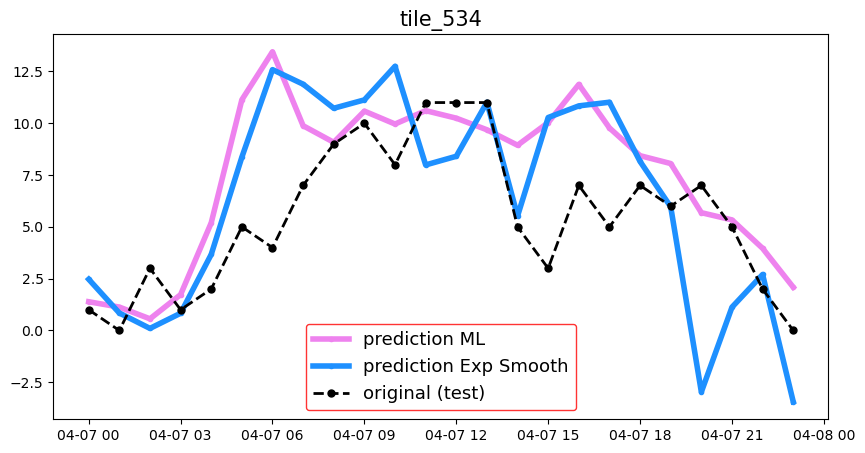

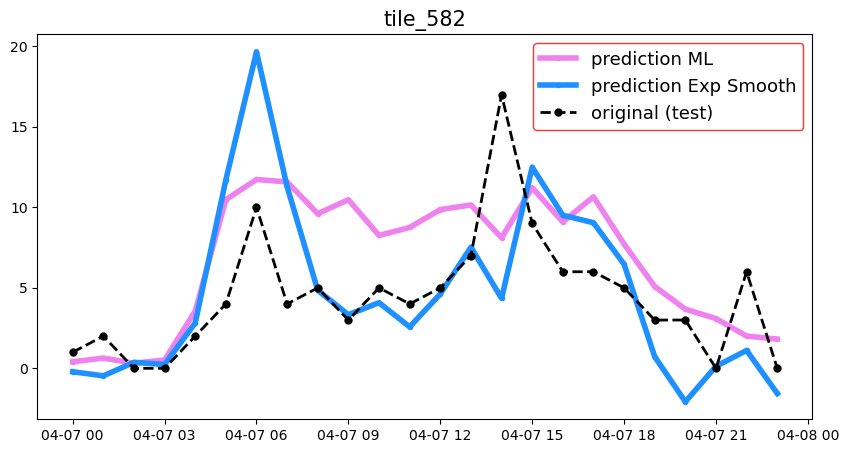

In [57]:
N_leaf_to_plot = 10

idx_plot = df_ts[list_tiles].T.iloc[:, -12:].sum(axis = 1).sort_values(ascending = False).head(N_leaf_to_plot).index

for leaf in idx_plot:
    
    fig, ax = plt.subplots(1, figsize = [10, 5])
    
    ax.plot(df_y_pred.loc[leaf, :], marker = 'o', markersize = 3, label = 'prediction ML', lw = 4, c = 'violet')
    ax.plot(df_y_pred_ExpSmooth.loc[leaf, :], marker = 'o', markersize = 3, label = 'prediction Exp Smooth', lw = 4, c = 'dodgerblue')
    ax.plot(df_y_test.loc[leaf, :], marker = 'o', markersize = 5, label = 'original (test)', linestyle = '--', lw = 2, c = 'black')     
            
    # Legend
    ax.legend(edgecolor = 'red', facecolor = 'white', fontsize = 13, loc = 'best')
    ax.set_title(leaf, fontsize = 15)
            
    plt.show()
